Import important parameter

In [1]:
inputsize = 25
e = 0.0125

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

Local DMM on fine grid

In [5]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=2)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.8355599979744923
Iteration 200/4000
Upper bound estimation = 0.8439854623354304
Iteration 300/4000
Upper bound estimation = 0.8221581840746818
Iteration 400/4000
Upper bound estimation = 0.8478067312138504
Iteration 500/4000
Upper bound estimation = 0.8399882739200085
Iteration 600/4000
Upper bound estimation = 0.8158368917713377
Iteration 700/4000
Upper bound estimation = 0.7981560141320422
Iteration 800/4000
Upper bound estimation = 0.81338722160211
Iteration 900/4000
Upper bound estimation = 0.8059865224170457
Iteration 1000/4000
Upper bound estimation = 0.7914848098725433
Iteration 1100/4000
Upper bound estimation = 0.795254154581267
Iteration 1200/4000
Upper bound estimation = 0.7536298681145444
Iteration 1300/4000
Upper bound estimation = 0.7948977310994709
Iteration 1400/4000
Upper bound estimation = 0.7677574512404016
Iteration 1500/4000
Upper bound estimation = 0.777626699571714
Iteration 1600/4000
Upper bound estimation = 0.760289

In [6]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.31723607097084094


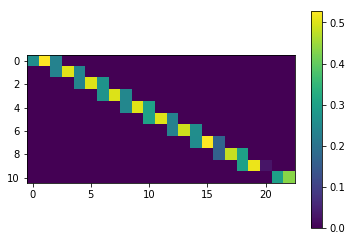

In [7]:
localR = opt_par[1][0]
LOCALR = np.zeros([outputsize-1,inputsize-2])
for i in range(outputsize-1):
    C = localR[i][:]
    for l in range(3):
        LOCALR[i][2*i+l] = C[l]
        
        
plt.imshow(LOCALR)
plt.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


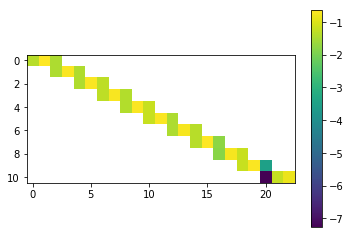

In [8]:
plt.imshow(np.log(np.abs(LOCALR)))
plt.colorbar()

In [9]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11841781696604974
L = 0.03
rho = 0.12011891962954463
L = 0.04
rho = 0.122382625881718
L = 0.05
rho = 0.12492325275955424
L = 0.060000000000000005
rho = 0.12760212435097767
L = 0.07
rho = 0.1303520428504363
L = 0.08
rho = 0.1331382619913994
L = 0.09
rho = 0.13594140876756539
L = 0.09999999999999999
rho = 0.13874991282057603
L = 0.10999999999999999
rho = 0.1415564503958655
L = 0.11999999999999998
rho = 0.14435615873199667
L = 0.12999999999999998
rho = 0.14714568040413212
L = 0.13999999999999999
rho = 0.1499226219668279
L = 0.15
rho = 0.1526852318894301
L = 0.16
rho = 0.1554322007794804
L = 0.17
rho = 0.15816253295952415
L = 0.18000000000000002
rho = 0.16087546133028274
L = 0.19000000000000003
rho = 0.16357038938600757
L = 0.20000000000000004
rho = 0.1662468507605885
L = 0.21000000000000005
rho = 0.16890448038119452
L = 0.22000000000000006
rho = 0.17154299348068489
L = 0.23000000000000007
rho = 0.17416217003792575
L = 0.24000000000000007
rho = 0.1767

the 87 steps
rho = 0.3249822706479679
the 88 steps
rho = 0.3249762452475299
the 89 steps
rho = 0.32497021989632024
the 90 steps
rho = 0.32496419459436837
the 91 steps
rho = 0.32495816934170463
the 92 steps
rho = 0.3249521441383603
the 93 steps
rho = 0.3249461189843655
the 94 steps
rho = 0.32494009387975137
the 95 steps
rho = 0.32493406882454945
the 96 steps
rho = 0.3249280438187886
the 97 steps
rho = 0.32492201886250194
the 98 steps
rho = 0.3249159939557197
the 99 steps
rho = 0.32490996909847253
the 100 steps
rho = 0.32490394429079217
the 101 steps
rho = 0.32489791953271124
the 102 steps
rho = 0.32489189482426
the 103 steps
rho = 0.32488587016546977
the 104 steps
rho = 0.3248798455563724
the 105 steps
rho = 0.3248738209969999
the 106 steps
rho = 0.32486779648738345
the 107 steps
rho = 0.32486177202755534
the 108 steps
rho = 0.32485574761754776
the 109 steps
rho = 0.3248497232573929
the 110 steps
rho = 0.3248436989471229
the 111 steps
rho = 0.324837674686769
the 112 steps
rho = 0.324831

the 290 steps
rho = 0.32376017131680535
the 291 steps
rho = 0.3237541566504306
the 292 steps
rho = 0.3237481420412108
the 293 steps
rho = 0.323742127489192
the 294 steps
rho = 0.32373611299442395
the 295 steps
rho = 0.3237300985569544
the 296 steps
rho = 0.3237240841768307
the 297 steps
rho = 0.32371806985410245
the 298 steps
rho = 0.3237120555888163
the 299 steps
rho = 0.32370604138102144
the 300 steps
rho = 0.32370002723076635
the 301 steps
rho = 0.32369401313809937
the 302 steps
rho = 0.32368799910306983
the 303 steps
rho = 0.3236819851257254
the 304 steps
rho = 0.32367597120611585
the 305 steps
rho = 0.3236699573442909
the 306 steps
rho = 0.32366394354029726
the 307 steps
rho = 0.32365792979418595
the 308 steps
rho = 0.3236519161060048
the 309 steps
rho = 0.32364590247580344
the 310 steps
rho = 0.32363988890363143
the 311 steps
rho = 0.3236338753895393
the 312 steps
rho = 0.32362786193357534
the 313 steps
rho = 0.3236218485357899
the 314 steps
rho = 0.3236158351962322
the 315 steps

the 481 steps
rho = 0.3226124666474157
the 482 steps
rho = 0.32260646386923536
the 483 steps
rho = 0.3226004611590053
the 484 steps
rho = 0.3225944585167899
the 485 steps
rho = 0.32258845594265306
the 486 steps
rho = 0.32258245343666303
the 487 steps
rho = 0.3225764509988841
the 488 steps
rho = 0.3225704486293839
the 489 steps
rho = 0.322564446328226
the 490 steps
rho = 0.32255844409547907
the 491 steps
rho = 0.3225524419312072
the 492 steps
rho = 0.3225464398354786
the 493 steps
rho = 0.32254043780835956
the 494 steps
rho = 0.3225344358499148
the 495 steps
rho = 0.3225284339602135
the 496 steps
rho = 0.32252243213932086
the 497 steps
rho = 0.32251643038730343
the 498 steps
rho = 0.3225104287042287
the 499 steps
rho = 0.3225044270901646
the 500 steps
rho = 0.32249842554517577
the 501 steps
rho = 0.322492424069333
the 502 steps
rho = 0.32248642266270056
the 503 steps
rho = 0.3224804213253479
the 504 steps
rho = 0.3224744200573404
the 505 steps
rho = 0.32246841885874766
the 506 steps
rho

the 682 steps
rho = 0.32140736807304704
the 683 steps
rho = 0.321401380405697
the 684 steps
rho = 0.3213953928215367
the 685 steps
rho = 0.32138940532065247
the 686 steps
rho = 0.32138341790313363
the 687 steps
rho = 0.3213774305690638
the 688 steps
rho = 0.32137144331853285
the 689 steps
rho = 0.3213654561516258
the 690 steps
rho = 0.3213594690684303
the 691 steps
rho = 0.321353482069035
the 692 steps
rho = 0.32134749515352573
the 693 steps
rho = 0.3213415083219913
the 694 steps
rho = 0.3213355215745179
the 695 steps
rho = 0.3213295349111958
the 696 steps
rho = 0.32132354833211024
the 697 steps
rho = 0.3213175618373518
the 698 steps
rho = 0.3213115754270068
the 699 steps
rho = 0.3213055891011631
the 700 steps
rho = 0.32129960285991094
the 701 steps
rho = 0.32129361670333834
the 702 steps
rho = 0.3212876306315323
the 703 steps
rho = 0.32128164464458414
the 704 steps
rho = 0.32127565874257985
the 705 steps
rho = 0.3212696729256104
the 706 steps
rho = 0.3212636871937644
the 707 steps
rho

the 883 steps
rho = 0.3202056422948434
the 884 steps
rho = 0.32019967324700593
the 885 steps
rho = 0.32019370430216265
the 886 steps
rho = 0.3201877354604244
the 887 steps
rho = 0.3201817667219024
the 888 steps
rho = 0.32017579808670843
the 889 steps
rho = 0.32016982955495316
the 890 steps
rho = 0.3201638611267496
the 891 steps
rho = 0.32015789280220686
the 892 steps
rho = 0.3201519245814402
the 893 steps
rho = 0.32014595646455885
the 894 steps
rho = 0.32013998845167696
the 895 steps
rho = 0.32013402054290513
the 896 steps
rho = 0.32012805273835643
the 897 steps
rho = 0.320122085038144
the 898 steps
rho = 0.3201161174423789
the 899 steps
rho = 0.3201101499511761
the 900 steps
rho = 0.320104182564647
the 901 steps
rho = 0.3200982152829049
the 902 steps
rho = 0.3200922481060614
the 903 steps
rho = 0.3200862810342337
the 904 steps
rho = 0.32008031406753307
the 905 steps
rho = 0.32007434720607136
the 906 steps
rho = 0.3200683804499652
the 907 steps
rho = 0.32006241379932654
the 908 steps
r

the 1085 steps
rho = 0.31900214488433265
the 1086 steps
rho = 0.3189961990791823
the 1087 steps
rho = 0.3189902534022397
the 1088 steps
rho = 0.31898430785364223
the 1089 steps
rho = 0.3189783624335298
the 1090 steps
rho = 0.31897241714204283
the 1091 steps
rho = 0.3189664719793212
the 1092 steps
rho = 0.318960526945503
the 1093 steps
rho = 0.3189545820407297
the 1094 steps
rho = 0.31894863726514294
the 1095 steps
rho = 0.3189426926188799
the 1096 steps
rho = 0.3189367481020833
the 1097 steps
rho = 0.3189308037148927
the 1098 steps
rho = 0.31892485945744997
the 1099 steps
rho = 0.3189189153298954
the 1100 steps
rho = 0.31891297133236957
the 1101 steps
rho = 0.31890702746501526
the 1102 steps
rho = 0.3189010837279721
the 1103 steps
rho = 0.3188951401213828
the 1104 steps
rho = 0.318889196645389
the 1105 steps
rho = 0.3188832533001319
the 1106 steps
rho = 0.3188773100857547
the 1107 steps
rho = 0.3188713670023985
the 1108 steps
rho = 0.3188654240502063
the 1109 steps
rho = 0.318859481229

the 1277 steps
rho = 0.3178630712471896
the 1278 steps
rho = 0.31785715279034
the 1279 steps
rho = 0.31785123449128355
the 1280 steps
rho = 0.31784531635019
the 1281 steps
rho = 0.31783939836723074
the 1282 steps
rho = 0.317833480542572
the 1283 steps
rho = 0.3178275628763879
the 1284 steps
rho = 0.31782164536884594
the 1285 steps
rho = 0.31781572802011737
the 1286 steps
rho = 0.31780981083037224
the 1287 steps
rho = 0.31780389379978247
the 1288 steps
rho = 0.3177979769285174
the 1289 steps
rho = 0.3177920602167494
the 1290 steps
rho = 0.317786143664649
the 1291 steps
rho = 0.31778022727238797
the 1292 steps
rho = 0.3177743110401372
the 1293 steps
rho = 0.31776839496806913
the 1294 steps
rho = 0.3177624790563553
the 1295 steps
rho = 0.3177565633051675
the 1296 steps
rho = 0.3177506477146794
the 1297 steps
rho = 0.317744732285061
the 1298 steps
rho = 0.3177388170164864
the 1299 steps
rho = 0.3177329019091283
the 1300 steps
rho = 0.3177269869631593
the 1301 steps
rho = 0.3177210721787523

the 1466 steps
rho = 0.31674748269321634
the 1467 steps
rho = 0.3167415972586367
the 1468 steps
rho = 0.3167357120169149
the 1469 steps
rho = 0.31672982696825097
the 1470 steps
rho = 0.31672394211284915
the 1471 steps
rho = 0.3167180574509091
the 1472 steps
rho = 0.316712172982636
the 1473 steps
rho = 0.3167062887082311
the 1474 steps
rho = 0.3167004046278985
the 1475 steps
rho = 0.31669452074183985
the 1476 steps
rho = 0.3166886370502583
the 1477 steps
rho = 0.316682753553358
the 1478 steps
rho = 0.3166768702513436
the 1479 steps
rho = 0.3166709871444168
the 1480 steps
rho = 0.3166651042327837
the 1481 steps
rho = 0.31665922151664666
the 1482 steps
rho = 0.31665333899621023
the 1483 steps
rho = 0.3166474566716806
the 1484 steps
rho = 0.31664157454326075
the 1485 steps
rho = 0.31663569261115504
the 1486 steps
rho = 0.3166298108755696
the 1487 steps
rho = 0.3166239293367097
the 1488 steps
rho = 0.3166180479947819
the 1489 steps
rho = 0.3166121668499876
the 1490 steps
rho = 0.31660628590

the 1673 steps
rho = 0.3155336171979505
the 1674 steps
rho = 0.31552777625186607
the 1675 steps
rho = 0.3155219355442681
the 1676 steps
rho = 0.315516095075394
the 1677 steps
rho = 0.31551025484548423
the 1678 steps
rho = 0.3155044148547765
the 1679 steps
rho = 0.3154985751035144
the 1680 steps
rho = 0.31549273559193425
the 1681 steps
rho = 0.31548689632027616
the 1682 steps
rho = 0.3154810572887814
the 1683 steps
rho = 0.3154752184976899
the 1684 steps
rho = 0.3154693799472413
the 1685 steps
rho = 0.3154635416376797
the 1686 steps
rho = 0.3154577035692419
the 1687 steps
rho = 0.31545186574217127
the 1688 steps
rho = 0.31544602815670886
the 1689 steps
rho = 0.31544019081309554
the 1690 steps
rho = 0.3154343537115718
the 1691 steps
rho = 0.3154285168523829
the 1692 steps
rho = 0.31542268023576714
the 1693 steps
rho = 0.3154168438619687
the 1694 steps
rho = 0.31541100773123004
the 1695 steps
rho = 0.3154051718437924
the 1696 steps
rho = 0.31539933619989907
the 1697 steps
rho = 0.31539350

the 1871 steps
rho = 0.31438207676299584
the 1872 steps
rho = 0.3143762879260773
the 1873 steps
rho = 0.31437049937842415
the 1874 steps
rho = 0.31436471112030745
the 1875 steps
rho = 0.31435892315200376
the 1876 steps
rho = 0.31435313547378435
the 1877 steps
rho = 0.3143473480859249
the 1878 steps
rho = 0.3143415609886999
the 1879 steps
rho = 0.3143357741823819
the 1880 steps
rho = 0.3143299876672467
the 1881 steps
rho = 0.3143242014435688
the 1882 steps
rho = 0.31431841551162326
the 1883 steps
rho = 0.3143126298716836
the 1884 steps
rho = 0.31430684452402785
the 1885 steps
rho = 0.31430105946892856
the 1886 steps
rho = 0.31429527470666263
the 1887 steps
rho = 0.3142894902375056
the 1888 steps
rho = 0.3142837060617323
the 1889 steps
rho = 0.31427792217962064
the 1890 steps
rho = 0.3142721385914455
the 1891 steps
rho = 0.31426635529748437
the 1892 steps
rho = 0.31426057229801063
the 1893 steps
rho = 0.3142547895933044
the 1894 steps
rho = 0.3142490071836412
the 1895 steps
rho = 0.31424

the 2069 steps
rho = 0.31324188703051137
the 2070 steps
rho = 0.31323616100412266
the 2071 steps
rho = 0.3132304353241874
the 2072 steps
rho = 0.31322470999100915
the 2073 steps
rho = 0.31321898500488954
the 2074 steps
rho = 0.31321326036613406
the 2075 steps
rho = 0.3132075360750438
the 2076 steps
rho = 0.31320181213192383
the 2077 steps
rho = 0.3131960885370789
the 2078 steps
rho = 0.31319036529081073
the 2079 steps
rho = 0.313184642393424
the 2080 steps
rho = 0.31317891984522406
the 2081 steps
rho = 0.3131731976465135
the 2082 steps
rho = 0.3131674757975965
the 2083 steps
rho = 0.3131617542987796
the 2084 steps
rho = 0.3131560331503657
the 2085 steps
rho = 0.3131503123526612
the 2086 steps
rho = 0.3131445919059695
the 2087 steps
rho = 0.3131388718105947
the 2088 steps
rho = 0.31313315206684444
the 2089 steps
rho = 0.31312743267502285
the 2090 steps
rho = 0.31312171363543434
the 2091 steps
rho = 0.31311599494838616
the 2092 steps
rho = 0.31311027661418267
the 2093 steps
rho = 0.31310

the 2275 steps
rho = 0.3120700847457742
the 2276 steps
rho = 0.31206443665362993
the 2277 steps
rho = 0.3120587889726901
the 2278 steps
rho = 0.31205314170327864
the 2279 steps
rho = 0.31204749484572025
the 2280 steps
rho = 0.3120418484003359
the 2281 steps
rho = 0.31203620236745083
the 2282 steps
rho = 0.3120305567473893
the 2283 steps
rho = 0.3120249115404717
the 2284 steps
rho = 0.3120192667470259
the 2285 steps
rho = 0.31201362236737257
the 2286 steps
rho = 0.31200797840183736
the 2287 steps
rho = 0.31200233485074347
the 2288 steps
rho = 0.31199669171441463
the 2289 steps
rho = 0.31199104899317665
the 2290 steps
rho = 0.3119854066873513
the 2291 steps
rho = 0.31197976479726375
the 2292 steps
rho = 0.31197412332323815
the 2293 steps
rho = 0.3119684822655982
the 2294 steps
rho = 0.3119628416246695
the 2295 steps
rho = 0.31195720140077626
the 2296 steps
rho = 0.3119515615942408
the 2297 steps
rho = 0.3119459222053894
the 2298 steps
rho = 0.3119402832345469
the 2299 steps
rho = 0.31193

the 2472 steps
rho = 0.3109657578993442
the 2473 steps
rho = 0.3109601971094857
the 2474 steps
rho = 0.3109546367951914
the 2475 steps
rho = 0.3109490769567832
the 2476 steps
rho = 0.31094351759459143
the 2477 steps
rho = 0.3109379587089429
the 2478 steps
rho = 0.3109324003001636
the 2479 steps
rho = 0.3109268423685804
the 2480 steps
rho = 0.31092128491452065
the 2481 steps
rho = 0.31091572793831035
the 2482 steps
rho = 0.31091017144027594
the 2483 steps
rho = 0.31090461542074543
the 2484 steps
rho = 0.31089905988004457
the 2485 steps
rho = 0.3108935048185014
the 2486 steps
rho = 0.3108879502364402
the 2487 steps
rho = 0.3108823961341897
the 2488 steps
rho = 0.31087684251207387
the 2489 steps
rho = 0.3108712893704227
the 2490 steps
rho = 0.3108657367095599
the 2491 steps
rho = 0.31086018452981234
the 2492 steps
rho = 0.3108546328315075
the 2493 steps
rho = 0.31084908161497093
the 2494 steps
rho = 0.3108435308805288
the 2495 steps
rho = 0.31083798062850715
the 2496 steps
rho = 0.3108324

the 2661 steps
rho = 0.30992357688889166
the 2662 steps
rho = 0.30991811172620193
the 2663 steps
rho = 0.3099126470996995
the 2664 steps
rho = 0.30990718300969466
the 2665 steps
rho = 0.3099017194564983
the 2666 steps
rho = 0.3098962564404212
the 2667 steps
rho = 0.3098907939617749
the 2668 steps
rho = 0.3098853320208685
the 2669 steps
rho = 0.3098798706180118
the 2670 steps
rho = 0.30987440975351693
the 2671 steps
rho = 0.30986894942769194
the 2672 steps
rho = 0.30986348964084764
the 2673 steps
rho = 0.3098580303932939
the 2674 steps
rho = 0.30985257168534036
the 2675 steps
rho = 0.30984711351729466
the 2676 steps
rho = 0.3098416558894673
the 2677 steps
rho = 0.30983619880216834
the 2678 steps
rho = 0.3098307422557061
the 2679 steps
rho = 0.30982528625038813
the 2680 steps
rho = 0.3098198307865251
the 2681 steps
rho = 0.3098143758644242
the 2682 steps
rho = 0.3098089214843932
the 2683 steps
rho = 0.3098034676467416
the 2684 steps
rho = 0.309798014351777
the 2685 steps
rho = 0.30979256

the 2857 steps
rho = 0.30886302594391324
the 2858 steps
rho = 0.3088576716038883
the 2859 steps
rho = 0.30885231785751066
the 2860 steps
rho = 0.3088469647050511
the 2861 steps
rho = 0.3088416121467823
the 2862 steps
rho = 0.30883626018297466
the 2863 steps
rho = 0.30883090881389635
the 2864 steps
rho = 0.30882555803981787
the 2865 steps
rho = 0.30882020786101055
the 2866 steps
rho = 0.30881485827774274
the 2867 steps
rho = 0.30880950929028345
the 2868 steps
rho = 0.30880416089890134
the 2869 steps
rho = 0.30879881310386587
the 2870 steps
rho = 0.30879346590544543
the 2871 steps
rho = 0.308788119303908
the 2872 steps
rho = 0.3087827732995204
the 2873 steps
rho = 0.3087774278925518
the 2874 steps
rho = 0.3087720830832681
the 2875 steps
rho = 0.3087667388719369
the 2876 steps
rho = 0.3087613952588255
the 2877 steps
rho = 0.308756052244199
the 2878 steps
rho = 0.3087507098283238
the 2879 steps
rho = 0.3087453680114676
the 2880 steps
rho = 0.3087400267938934
the 2881 steps
rho = 0.30873468

the 3045 steps
rho = 0.3078671259874352
the 3046 steps
rho = 0.3078618876963143
the 3047 steps
rho = 0.3078566500444473
the 3048 steps
rho = 0.3078514130320442
the 3049 steps
rho = 0.30784617665931596
the 3050 steps
rho = 0.30784094092647213
the 3051 steps
rho = 0.3078357058337198
the 3052 steps
rho = 0.30783047138127123
the 3053 steps
rho = 0.3078252375693315
the 3054 steps
rho = 0.3078200043981115
the 3055 steps
rho = 0.30781477186781603
the 3056 steps
rho = 0.3078095399786547
the 3057 steps
rho = 0.30780430873083364
the 3058 steps
rho = 0.30779907812455853
the 3059 steps
rho = 0.30779384816003696
the 3060 steps
rho = 0.30778861883747416
the 3061 steps
rho = 0.3077833901570745
the 3062 steps
rho = 0.3077781621190441
the 3063 steps
rho = 0.3077729347235878
the 3064 steps
rho = 0.3077677079709095
the 3065 steps
rho = 0.3077624818612116
the 3066 steps
rho = 0.30775725639469953
the 3067 steps
rho = 0.3077520315715755
the 3068 steps
rho = 0.3077468073920426
the 3069 steps
rho = 0.30774158

the 3238 steps
rho = 0.3068682058033083
the 3239 steps
rho = 0.30686309431247905
the 3240 steps
rho = 0.3068579834939388
the 3241 steps
rho = 0.30685287334781475
the 3242 steps
rho = 0.30684776387423635
the 3243 steps
rho = 0.30684265507333214
the 3244 steps
rho = 0.30683754694522875
the 3245 steps
rho = 0.30683243949005395
the 3246 steps
rho = 0.30682733270793217
the 3247 steps
rho = 0.3068222265989932
the 3248 steps
rho = 0.30681712116336063
the 3249 steps
rho = 0.306812016401159
the 3250 steps
rho = 0.3068069123125146
the 3251 steps
rho = 0.3068018088975511
the 3252 steps
rho = 0.3067967061563917
the 3253 steps
rho = 0.3067916040891611
the 3254 steps
rho = 0.3067865026959816
the 3255 steps
rho = 0.3067814019769754
the 3256 steps
rho = 0.3067763019322642
the 3257 steps
rho = 0.3067712025619693
the 3258 steps
rho = 0.3067661038662132
the 3259 steps
rho = 0.30676100584511545
the 3260 steps
rho = 0.30675590849879575
the 3261 steps
rho = 0.30675081182737424
the 3262 steps
rho = 0.3067457

the 3443 steps
rho = 0.30583455646472696
the 3444 steps
rho = 0.3058295848187063
the 3445 steps
rho = 0.30582461386142995
the 3446 steps
rho = 0.3058196435929264
the 3447 steps
rho = 0.305814674013226
the 3448 steps
rho = 0.30580970512235917
the 3449 steps
rho = 0.3058047369203531
the 3450 steps
rho = 0.3057997694072353
the 3451 steps
rho = 0.3057948025830343
the 3452 steps
rho = 0.30578983644777596
the 3453 steps
rho = 0.3057848710014872
the 3454 steps
rho = 0.3057799062441945
the 3455 steps
rho = 0.30577494217592344
the 3456 steps
rho = 0.30576997879669676
the 3457 steps
rho = 0.3057650161065417
the 3458 steps
rho = 0.3057600541054816
the 3459 steps
rho = 0.30575509279353946
the 3460 steps
rho = 0.30575013217073843
the 3461 steps
rho = 0.3057451722371012
the 3462 steps
rho = 0.30574021299264925
the 3463 steps
rho = 0.3057352544374044
the 3464 steps
rho = 0.30573029657138845
the 3465 steps
rho = 0.3057253393946205
the 3466 steps
rho = 0.3057203829071222
the 3467 steps
rho = 0.30571542

the 3638 steps
rho = 0.3048781206545115
the 3639 steps
rho = 0.3048732832794839
the 3640 steps
rho = 0.30486844658973455
the 3641 steps
rho = 0.30486361058520023
the 3642 steps
rho = 0.3048587752658132
the 3643 steps
rho = 0.3048539406315075
the 3644 steps
rho = 0.3048491066822173
the 3645 steps
rho = 0.30484427341787523
the 3646 steps
rho = 0.30483944083841463
the 3647 steps
rho = 0.3048346089437667
the 3648 steps
rho = 0.30482977773386183
the 3649 steps
rho = 0.3048249472086334
the 3650 steps
rho = 0.3048201173680099
the 3651 steps
rho = 0.304815288211923
the 3652 steps
rho = 0.30481045974030074
the 3653 steps
rho = 0.3048056319530745
the 3654 steps
rho = 0.3048008048501706
the 3655 steps
rho = 0.30479597843151895
the 3656 steps
rho = 0.3047911526970471
the 3657 steps
rho = 0.30478632764668157
the 3658 steps
rho = 0.3047815032803498
the 3659 steps
rho = 0.3047766795979785
the 3660 steps
rho = 0.3047718565994927
the 3661 steps
rho = 0.3047670342848187
the 3662 steps
rho = 0.3047622126

the 3840 steps
rho = 0.30391476362308356
the 3841 steps
rho = 0.3039100627346768
the 3842 steps
rho = 0.3039053625092587
the 3843 steps
rho = 0.30390066294667534
the 3844 steps
rho = 0.3038959640467752
the 3845 steps
rho = 0.30389126580940334
the 3846 steps
rho = 0.30388656823440485
the 3847 steps
rho = 0.3038818713216244
the 3848 steps
rho = 0.3038771750709075
the 3849 steps
rho = 0.30387247948209795
the 3850 steps
rho = 0.30386778455503966
the 3851 steps
rho = 0.3038630902895764
the 3852 steps
rho = 0.30385839668555165
the 3853 steps
rho = 0.3038537037428069
the 3854 steps
rho = 0.3038490114611861
the 3855 steps
rho = 0.30384431984052984
the 3856 steps
rho = 0.3038396288806811
the 3857 steps
rho = 0.3038349385814793
the 3858 steps
rho = 0.3038302489427664
the 3859 steps
rho = 0.30382555996438354
the 3860 steps
rho = 0.30382087164616917
the 3861 steps
rho = 0.30381618398796323
the 3862 steps
rho = 0.30381149698960486
the 3863 steps
rho = 0.30380681065093423
the 3864 steps
rho = 0.3038

the 4045 steps
rho = 0.30296470094086503
the 4046 steps
rho = 0.30296013223792173
the 4047 steps
rho = 0.30295556415902647
the 4048 steps
rho = 0.30295099670395587
the 4049 steps
rho = 0.3029464298724885
the 4050 steps
rho = 0.3029418636643986
the 4051 steps
rho = 0.3029372980794633
the 4052 steps
rho = 0.30293273311745805
the 4053 steps
rho = 0.3029281687781598
the 4054 steps
rho = 0.30292360506134247
the 4055 steps
rho = 0.3029190419667793
the 4056 steps
rho = 0.3029144794942483
the 4057 steps
rho = 0.3029099176435221
the 4058 steps
rho = 0.30290535641437494
the 4059 steps
rho = 0.3029007958065813
the 4060 steps
rho = 0.30289623581991526
the 4061 steps
rho = 0.3028916764541473
the 4062 steps
rho = 0.3028871177090535
the 4063 steps
rho = 0.3028825595844052
the 4064 steps
rho = 0.3028780020799754
the 4065 steps
rho = 0.3028734451955361
the 4066 steps
rho = 0.30286888893085917
the 4067 steps
rho = 0.3028643332857166
the 4068 steps
rho = 0.30285977825987936
the 4069 steps
rho = 0.3028552

the 4258 steps
rho = 0.3020052813001586
the 4259 steps
rho = 0.3020008400846362
the 4260 steps
rho = 0.3019963994402234
the 4261 steps
rho = 0.30199195936664897
the 4262 steps
rho = 0.30198751986364414
the 4263 steps
rho = 0.3019830809309389
the 4264 steps
rho = 0.3019786425682631
the 4265 steps
rho = 0.30197420477534453
the 4266 steps
rho = 0.3019697675519158
the 4267 steps
rho = 0.3019653308977034
the 4268 steps
rho = 0.3019608948124377
the 4269 steps
rho = 0.301956459295848
the 4270 steps
rho = 0.3019520243476621
the 4271 steps
rho = 0.30194758996761056
the 4272 steps
rho = 0.30194315615542044
the 4273 steps
rho = 0.3019387229108201
the 4274 steps
rho = 0.3019342902335384
the 4275 steps
rho = 0.30192985812330353
the 4276 steps
rho = 0.3019254265798429
the 4277 steps
rho = 0.30192099560288477
the 4278 steps
rho = 0.3019165651921558
the 4279 steps
rho = 0.30191213534738515
the 4280 steps
rho = 0.30190770606829825
the 4281 steps
rho = 0.30190327735462585
the 4282 steps
rho = 0.30189884

the 4462 steps
rho = 0.30111071326397354
the 4463 steps
rho = 0.30110638279072066
the 4464 steps
rho = 0.3011020528310874
the 4465 steps
rho = 0.301097723384786
the 4466 steps
rho = 0.30109339445152566
the 4467 steps
rho = 0.3010890660310148
the 4468 steps
rho = 0.3010847381229636
the 4469 steps
rho = 0.30108041072708247
the 4470 steps
rho = 0.3010760838430794
the 4471 steps
rho = 0.3010717574706646
the 4472 steps
rho = 0.30106743160954785
the 4473 steps
rho = 0.3010631062594374
the 4474 steps
rho = 0.3010587814200442
the 4475 steps
rho = 0.30105445709107664
the 4476 steps
rho = 0.3010501332722435
the 4477 steps
rho = 0.30104580996325475
the 4478 steps
rho = 0.3010414871638187
the 4479 steps
rho = 0.3010371648736456
the 4480 steps
rho = 0.3010328430924442
the 4481 steps
rho = 0.30102852181992396
the 4482 steps
rho = 0.3010242010557932
the 4483 steps
rho = 0.30101988079975944
the 4484 steps
rho = 0.301015561051534
the 4485 steps
rho = 0.30101124181082467
the 4486 steps
rho = 0.301006923

the 4671 steps
rho = 0.3002163708854663
the 4672 steps
rho = 0.3002121414139156
the 4673 steps
rho = 0.30020791239496303
the 4674 steps
rho = 0.3002036838283175
the 4675 steps
rho = 0.30019945571368783
the 4676 steps
rho = 0.3001952280507857
the 4677 steps
rho = 0.300191000839318
the 4678 steps
rho = 0.30018677407899585
the 4679 steps
rho = 0.30018254776952846
the 4680 steps
rho = 0.30017832191062477
the 4681 steps
rho = 0.30017409650199534
the 4682 steps
rho = 0.3001698715433484
the 4683 steps
rho = 0.300165647034395
the 4684 steps
rho = 0.3001614229748447
the 4685 steps
rho = 0.3001571993644059
the 4686 steps
rho = 0.3001529762027904
the 4687 steps
rho = 0.30014875348970727
the 4688 steps
rho = 0.3001445312248657
the 4689 steps
rho = 0.300140309407976
the 4690 steps
rho = 0.30013608803875
the 4691 steps
rho = 0.30013186711689527
the 4692 steps
rho = 0.30012764664212266
the 4693 steps
rho = 0.3001234266141431
the 4694 steps
rho = 0.3001192070326658
the 4695 steps
rho = 0.3001149878974

the 4871 steps
rho = 0.29937910489136965
the 4872 steps
rho = 0.29937496022780397
the 4873 steps
rho = 0.2993708159599031
the 4874 steps
rho = 0.29936667208739176
the 4875 steps
rho = 0.2993625286099917
the 4876 steps
rho = 0.29935838552742755
the 4877 steps
rho = 0.29935424283942225
the 4878 steps
rho = 0.2993501005456993
the 4879 steps
rho = 0.29934595864598335
the 4880 steps
rho = 0.29934181713999747
the 4881 steps
rho = 0.29933767602746647
the 4882 steps
rho = 0.2993335353081141
the 4883 steps
rho = 0.2993293949816641
the 4884 steps
rho = 0.29932525504784113
the 4885 steps
rho = 0.29932111550637075
the 4886 steps
rho = 0.29931697635697574
the 4887 steps
rho = 0.2993128375993817
the 4888 steps
rho = 0.29930869923331166
the 4889 steps
rho = 0.2993045612584927
the 4890 steps
rho = 0.2993004236746486
the 4891 steps
rho = 0.29929628648150325
the 4892 steps
rho = 0.299292149678784
the 4893 steps
rho = 0.2992880132662148
the 4894 steps
rho = 0.29928387724352107
the 4895 steps
rho = 0.2992

the 5075 steps
rho = 0.29854140776345234
the 5076 steps
rho = 0.2985373382355063
the 5077 steps
rho = 0.29853326904905764
the 5078 steps
rho = 0.2985292002038548
the 5079 steps
rho = 0.2985251316996423
the 5080 steps
rho = 0.2985210635361695
the 5081 steps
rho = 0.29851699571318135
the 5082 steps
rho = 0.2985129282304268
the 5083 steps
rho = 0.298508861087654
the 5084 steps
rho = 0.2985047942846094
the 5085 steps
rho = 0.2985007278210418
the 5086 steps
rho = 0.29849666169669903
the 5087 steps
rho = 0.29849259591132754
the 5088 steps
rho = 0.29848853046467805
the 5089 steps
rho = 0.29848446535649803
the 5090 steps
rho = 0.2984804005865362
the 5091 steps
rho = 0.2984763361545398
the 5092 steps
rho = 0.2984722720602583
the 5093 steps
rho = 0.29846820830344123
the 5094 steps
rho = 0.29846414488383843
the 5095 steps
rho = 0.2984600818011963
the 5096 steps
rho = 0.29845601905526803
the 5097 steps
rho = 0.2984519566457993
the 5098 steps
rho = 0.2984478945725415
the 5099 steps
rho = 0.29844383

the 5265 steps
rho = 0.2977740514120542
the 5266 steps
rho = 0.2977700423781091
the 5267 steps
rho = 0.2977660336400518
the 5268 steps
rho = 0.29776202519765527
the 5269 steps
rho = 0.2977580170506939
the 5270 steps
rho = 0.29775400919894024
the 5271 steps
rho = 0.2977500016421702
the 5272 steps
rho = 0.29774599438015686
the 5273 steps
rho = 0.29774198741267394
the 5274 steps
rho = 0.29773798073949753
the 5275 steps
rho = 0.29773397436040117
the 5276 steps
rho = 0.2977299682751599
the 5277 steps
rho = 0.2977259624835483
the 5278 steps
rho = 0.2977219569853429
the 5279 steps
rho = 0.2977179517803168
the 5280 steps
rho = 0.2977139468682469
the 5281 steps
rho = 0.29770994224890807
the 5282 steps
rho = 0.2977059379220765
the 5283 steps
rho = 0.29770193388752714
the 5284 steps
rho = 0.2976979301450365
the 5285 steps
rho = 0.29769392669438144
the 5286 steps
rho = 0.2976899235353367
the 5287 steps
rho = 0.2976859206676788
the 5288 steps
rho = 0.2976819180911865
the 5289 steps
rho = 0.29767791

the 5471 steps
rho = 0.29695412385384173
the 5472 steps
rho = 0.2969501712062926
the 5473 steps
rho = 0.2969462188111475
the 5474 steps
rho = 0.29694226666821244
the 5475 steps
rho = 0.2969383147772922
the 5476 steps
rho = 0.2969343631381912
the 5477 steps
rho = 0.2969304117507137
the 5478 steps
rho = 0.29692646061466593
the 5479 steps
rho = 0.29692250972985224
the 5480 steps
rho = 0.296918559096079
the 5481 steps
rho = 0.2969146087131507
the 5482 steps
rho = 0.29691065858087423
the 5483 steps
rho = 0.29690670869905444
the 5484 steps
rho = 0.29690275906749786
the 5485 steps
rho = 0.2968988096860108
the 5486 steps
rho = 0.2968948605543995
the 5487 steps
rho = 0.2968909116724706
the 5488 steps
rho = 0.29688696304003087
the 5489 steps
rho = 0.2968830146568861
the 5490 steps
rho = 0.2968790665228435
the 5491 steps
rho = 0.29687511863771143
the 5492 steps
rho = 0.2968711710012959
the 5493 steps
rho = 0.29686722361340584
the 5494 steps
rho = 0.29686327647384536
the 5495 steps
rho = 0.2968593

the 5676 steps
rho = 0.29614884308895917
the 5677 steps
rho = 0.29614493831011574
the 5678 steps
rho = 0.2961410337467465
the 5679 steps
rho = 0.2961371293986858
the 5680 steps
rho = 0.2961332252657699
the 5681 steps
rho = 0.296129321347835
the 5682 steps
rho = 0.29612541764471445
the 5683 steps
rho = 0.2961215141562449
the 5684 steps
rho = 0.29611761088226324
the 5685 steps
rho = 0.29611370782260377
the 5686 steps
rho = 0.29610980497710393
the 5687 steps
rho = 0.2961059023456001
the 5688 steps
rho = 0.29610199992792846
the 5689 steps
rho = 0.29609809772392515
the 5690 steps
rho = 0.29609419573342793
the 5691 steps
rho = 0.2960902939562727
the 5692 steps
rho = 0.2960863923922975
the 5693 steps
rho = 0.2960824910413388
the 5694 steps
rho = 0.2960785899032337
the 5695 steps
rho = 0.2960746889778203
the 5696 steps
rho = 0.29607078826493666
the 5697 steps
rho = 0.2960668877644193
the 5698 steps
rho = 0.2960629874761072
the 5699 steps
rho = 0.29605908739983794
the 5700 steps
rho = 0.2960551

the 5848 steps
rho = 0.2954802576271404
the 5849 steps
rho = 0.2954763876062448
the 5850 steps
rho = 0.2954725177745893
the 5851 steps
rho = 0.2954686481320325
the 5852 steps
rho = 0.29546477867843435
the 5853 steps
rho = 0.29546090941365566
the 5854 steps
rho = 0.29545704033755743
the 5855 steps
rho = 0.29545317144999755
the 5856 steps
rho = 0.2954493027508377
the 5857 steps
rho = 0.29544543423993924
the 5858 steps
rho = 0.29544156591716014
the 5859 steps
rho = 0.29543769778236384
the 5860 steps
rho = 0.2954338298354107
the 5861 steps
rho = 0.2954299620761608
the 5862 steps
rho = 0.2954260945044764
the 5863 steps
rho = 0.29542222712021854
the 5864 steps
rho = 0.29541835992324866
the 5865 steps
rho = 0.29541449291342775
the 5866 steps
rho = 0.29541062609061935
the 5867 steps
rho = 0.2954067594546842
the 5868 steps
rho = 0.2954028930054835
the 5869 steps
rho = 0.29539902674288154
the 5870 steps
rho = 0.29539516066673843
the 5871 steps
rho = 0.29539129477691795
the 5872 steps
rho = 0.295

the 6033 steps
rho = 0.2947673854001211
the 6034 steps
rho = 0.2947635481416749
the 6035 steps
rho = 0.29475971104881005
the 6036 steps
rho = 0.29475587412140863
the 6037 steps
rho = 0.294752037359357
the 6038 steps
rho = 0.2947482007625383
the 6039 steps
rho = 0.2947443643308388
the 6040 steps
rho = 0.2947405280641428
the 6041 steps
rho = 0.29473669196233354
the 6042 steps
rho = 0.29473285602529914
the 6043 steps
rho = 0.29472902025292147
the 6044 steps
rho = 0.29472518464508846
the 6045 steps
rho = 0.29472134920168436
the 6046 steps
rho = 0.29471751392259493
the 6047 steps
rho = 0.29471367880770694
the 6048 steps
rho = 0.29470984385690513
the 6049 steps
rho = 0.29470600907007477
the 6050 steps
rho = 0.29470217444710245
the 6051 steps
rho = 0.29469833998787576
the 6052 steps
rho = 0.2946945056922802
the 6053 steps
rho = 0.2946906715602007
the 6054 steps
rho = 0.2946868375915261
the 6055 steps
rho = 0.2946830037861428
the 6056 steps
rho = 0.29467917014393624
the 6057 steps
rho = 0.2946

the 6215 steps
rho = 0.29407162283798965
the 6216 steps
rho = 0.2940678139326642
the 6217 steps
rho = 0.2940640051738972
the 6218 steps
rho = 0.29406019656159454
the 6219 steps
rho = 0.2940563880956635
the 6220 steps
rho = 0.29405257977600996
the 6221 steps
rho = 0.29404877160254184
the 6222 steps
rho = 0.29404496357516496
the 6223 steps
rho = 0.29404115569378664
the 6224 steps
rho = 0.29403734795831366
the 6225 steps
rho = 0.2940335403686537
the 6226 steps
rho = 0.29402973292471324
the 6227 steps
rho = 0.29402592562640106
the 6228 steps
rho = 0.2940221184736244
the 6229 steps
rho = 0.29401831146629037
the 6230 steps
rho = 0.29401450460430717
the 6231 steps
rho = 0.29401069788758194
the 6232 steps
rho = 0.2940068913160234
the 6233 steps
rho = 0.2940030848895396
the 6234 steps
rho = 0.29399927860803865
the 6235 steps
rho = 0.29399547247142865
the 6236 steps
rho = 0.29399166647961933
the 6237 steps
rho = 0.2939878606325179
the 6238 steps
rho = 0.29398405493003343
the 6239 steps
rho = 0.2

the 6395 steps
rho = 0.29338829625059276
the 6396 steps
rho = 0.2933845123253677
the 6397 steps
rho = 0.29338072853164615
the 6398 steps
rho = 0.2933769448693569
the 6399 steps
rho = 0.2933731613384243
the 6400 steps
rho = 0.2933693779387747
the 6401 steps
rho = 0.29336559467033496
the 6402 steps
rho = 0.2933618115330309
the 6403 steps
rho = 0.29335802852679016
the 6404 steps
rho = 0.29335424565153895
the 6405 steps
rho = 0.2933504629072032
the 6406 steps
rho = 0.2933466802937109
the 6407 steps
rho = 0.2933428978109884
the 6408 steps
rho = 0.29333911545896363
the 6409 steps
rho = 0.293335333237563
the 6410 steps
rho = 0.2933315511467143
the 6411 steps
rho = 0.29332776918634434
the 6412 steps
rho = 0.29332398735638154
the 6413 steps
rho = 0.2933202056567523
the 6414 steps
rho = 0.2933164240873852
the 6415 steps
rho = 0.29331264264820794
the 6416 steps
rho = 0.29330886133914824
the 6417 steps
rho = 0.2933050801601346
the 6418 steps
rho = 0.2933012991110942
the 6419 steps
rho = 0.29329751

the 6579 steps
rho = 0.29269419716844464
the 6580 steps
rho = 0.2926904362976673
the 6581 steps
rho = 0.2926866755464606
the 6582 steps
rho = 0.2926829149147664
the 6583 steps
rho = 0.29267915440252995
the 6584 steps
rho = 0.292675394009696
the 6585 steps
rho = 0.29267163373620825
the 6586 steps
rho = 0.2926678735820107
the 6587 steps
rho = 0.292664113547047
the 6588 steps
rho = 0.29266035363126325
the 6589 steps
rho = 0.2926565938346029
the 6590 steps
rho = 0.2926528341570116
the 6591 steps
rho = 0.2926490745984326
the 6592 steps
rho = 0.29264531515881126
the 6593 steps
rho = 0.292641555838094
the 6594 steps
rho = 0.2926377966362238
the 6595 steps
rho = 0.2926340375531461
the 6596 steps
rho = 0.2926302785888073
the 6597 steps
rho = 0.29262651974315207
the 6598 steps
rho = 0.2926227610161246
the 6599 steps
rho = 0.29261900240767197
the 6600 steps
rho = 0.29261524391773885
the 6601 steps
rho = 0.2926114855462717
the 6602 steps
rho = 0.2926077272932157
the 6603 steps
rho = 0.292603969158

the 6759 steps
rho = 0.2920191168467365
the 6760 steps
rho = 0.2920153766793326
the 6761 steps
rho = 0.2920116366228075
the 6762 steps
rho = 0.2920078966771224
the 6763 steps
rho = 0.29200415684223485
the 6764 steps
rho = 0.2920004171181056
the 6765 steps
rho = 0.29199667750469327
the 6766 steps
rho = 0.29199293800195864
the 6767 steps
rho = 0.2919891986098607
the 6768 steps
rho = 0.29198545932835795
the 6769 steps
rho = 0.29198172015741264
the 6770 steps
rho = 0.2919779810969831
the 6771 steps
rho = 0.2919742421470298
the 6772 steps
rho = 0.2919705033075117
the 6773 steps
rho = 0.29196676457839127
the 6774 steps
rho = 0.29196302595962675
the 6775 steps
rho = 0.29195928745117833
the 6776 steps
rho = 0.2919555490530078
the 6777 steps
rho = 0.2919518107650759
the 6778 steps
rho = 0.2919480725873409
the 6779 steps
rho = 0.2919443345197645
the 6780 steps
rho = 0.2919405965623077
the 6781 steps
rho = 0.2919368587149313
the 6782 steps
rho = 0.2919331209775963
the 6783 steps
rho = 0.291929383

the 6944 steps
rho = 0.29132903442041125
the 6945 steps
rho = 0.29132531415233204
the 6946 steps
rho = 0.2913215939888899
the 6947 steps
rho = 0.29131787393005865
the 6948 steps
rho = 0.2913141539758102
the 6949 steps
rho = 0.29131043412611823
the 6950 steps
rho = 0.29130671438095634
the 6951 steps
rho = 0.29130299474029675
the 6952 steps
rho = 0.291299275204113
the 6953 steps
rho = 0.29129555577237964
the 6954 steps
rho = 0.29129183644506934
the 6955 steps
rho = 0.29128811722215575
the 6956 steps
rho = 0.2912843981036122
the 6957 steps
rho = 0.2912806790894131
the 6958 steps
rho = 0.2912769601795311
the 6959 steps
rho = 0.2912732413739409
the 6960 steps
rho = 0.2912695226726158
the 6961 steps
rho = 0.2912658040755297
the 6962 steps
rho = 0.2912620855826578
the 6963 steps
rho = 0.2912583671939724
the 6964 steps
rho = 0.29125464890944935
the 6965 steps
rho = 0.2912509307290614
the 6966 steps
rho = 0.29124721265278397
the 6967 steps
rho = 0.2912434946805899
the 6968 steps
rho = 0.2912397

the 7132 steps
rho = 0.29063143725856905
the 7133 steps
rho = 0.2906277362596089
the 7134 steps
rho = 0.29062403536135695
the 7135 steps
rho = 0.29062033456379655
the 7136 steps
rho = 0.29061663386691267
the 7137 steps
rho = 0.2906129332706934
the 7138 steps
rho = 0.2906092327751205
the 7139 steps
rho = 0.2906055323801809
the 7140 steps
rho = 0.2906018320858586
the 7141 steps
rho = 0.2905981318921405
the 7142 steps
rho = 0.290594431799011
the 7143 steps
rho = 0.2905907318064548
the 7144 steps
rho = 0.290587031914459
the 7145 steps
rho = 0.2905833321230076
the 7146 steps
rho = 0.29057963243208795
the 7147 steps
rho = 0.29057593284168454
the 7148 steps
rho = 0.29057223335178245
the 7149 steps
rho = 0.29056853396236865
the 7150 steps
rho = 0.29056483467342864
the 7151 steps
rho = 0.2905611354849486
the 7152 steps
rho = 0.29055743639691367
the 7153 steps
rho = 0.2905537374093107
the 7154 steps
rho = 0.2905500385221243
the 7155 steps
rho = 0.2905463397353427
the 7156 steps
rho = 0.290542641

the 7317 steps
rho = 0.28994845355203785
the 7318 steps
rho = 0.28994477098632215
the 7319 steps
rho = 0.28994108851947614
the 7320 steps
rho = 0.2899374061514929
the 7321 steps
rho = 0.28993372388236904
the 7322 steps
rho = 0.2899300417120995
the 7323 steps
rho = 0.28992635964067814
the 7324 steps
rho = 0.28992267766810237
the 7325 steps
rho = 0.28991899579436475
the 7326 steps
rho = 0.2899153140194622
the 7327 steps
rho = 0.2899116323433894
the 7328 steps
rho = 0.28990795076614206
the 7329 steps
rho = 0.28990426928771557
the 7330 steps
rho = 0.28990058790810463
the 7331 steps
rho = 0.28989690662730494
the 7332 steps
rho = 0.2898932254453129
the 7333 steps
rho = 0.2898895443621244
the 7334 steps
rho = 0.2898858633777328
the 7335 steps
rho = 0.28988218249213576
the 7336 steps
rho = 0.28987850170532786
the 7337 steps
rho = 0.28987482101730655
the 7338 steps
rho = 0.2898711404280651
the 7339 steps
rho = 0.2898674599376015
the 7340 steps
rho = 0.2898637795459114
the 7341 steps
rho = 0.289

the 7500 steps
rho = 0.28927618756850076
the 7501 steps
rho = 0.28927252305912565
the 7502 steps
rho = 0.2892688586484697
the 7503 steps
rho = 0.28926519433653713
the 7504 steps
rho = 0.2892615301233295
the 7505 steps
rho = 0.2892578660088514
the 7506 steps
rho = 0.28925420199310725
the 7507 steps
rho = 0.2892505380760977
the 7508 steps
rho = 0.28924687425782797
the 7509 steps
rho = 0.2892432105383015
the 7510 steps
rho = 0.2892395469175217
the 7511 steps
rho = 0.28923588339549083
the 7512 steps
rho = 0.28923221997221404
the 7513 steps
rho = 0.28922855664769387
the 7514 steps
rho = 0.2892248934219354
the 7515 steps
rho = 0.2892212302949404
the 7516 steps
rho = 0.2892175672667144
the 7517 steps
rho = 0.2892139043372594
the 7518 steps
rho = 0.28921024150658076
the 7519 steps
rho = 0.28920657877468303
the 7520 steps
rho = 0.2892029161415677
the 7521 steps
rho = 0.2891992536072397
the 7522 steps
rho = 0.2891955911717033
the 7523 steps
rho = 0.28919192883496275
the 7524 steps
rho = 0.289188

the 7693 steps
rho = 0.28857077232664646
the 7694 steps
rho = 0.2885671269755317
the 7695 steps
rho = 0.28856348172446394
the 7696 steps
rho = 0.28855983657345285
the 7697 steps
rho = 0.28855619152250983
the 7698 steps
rho = 0.2885525465716443
the 7699 steps
rho = 0.2885489017208671
the 7700 steps
rho = 0.2885452569701898
the 7701 steps
rho = 0.2885416123196204
the 7702 steps
rho = 0.2885379677691714
the 7703 steps
rho = 0.28853432331885237
the 7704 steps
rho = 0.28853067896867535
the 7705 steps
rho = 0.28852703471864893
the 7706 steps
rho = 0.28852339056878457
the 7707 steps
rho = 0.28851974651909357
the 7708 steps
rho = 0.2885161025695853
the 7709 steps
rho = 0.28851245872027226
the 7710 steps
rho = 0.2885088149711635
the 7711 steps
rho = 0.2885051713222703
the 7712 steps
rho = 0.288501527773604
the 7713 steps
rho = 0.2884978843251756
the 7714 steps
rho = 0.28849424097699566
the 7715 steps
rho = 0.2884905977290744
the 7716 steps
rho = 0.2884869545814243
the 7717 steps
rho = 0.2884833

the 7887 steps
rho = 0.28786546131528024
the 7888 steps
rho = 0.28786183560293044
the 7889 steps
rho = 0.28785820999318673
the 7890 steps
rho = 0.2878545844860662
the 7891 steps
rho = 0.2878509590815842
the 7892 steps
rho = 0.287847333779756
the 7893 steps
rho = 0.2878437085805992
the 7894 steps
rho = 0.28784008348412804
the 7895 steps
rho = 0.28783645849035994
the 7896 steps
rho = 0.28783283359930967
the 7897 steps
rho = 0.2878292088109939
the 7898 steps
rho = 0.2878255841254284
the 7899 steps
rho = 0.28782195954262896
the 7900 steps
rho = 0.2878183350626124
the 7901 steps
rho = 0.28781471068539455
the 7902 steps
rho = 0.2878110864109914
the 7903 steps
rho = 0.2878074622394194
the 7904 steps
rho = 0.2878038381706944
the 7905 steps
rho = 0.28780021420483226
the 7906 steps
rho = 0.28779659034185073
the 7907 steps
rho = 0.2877929665817646
the 7908 steps
rho = 0.2877893429245908
the 7909 steps
rho = 0.2877857193703447
the 7910 steps
rho = 0.2877820959190437
the 7911 steps
rho = 0.28777847

the 8078 steps
rho = 0.2871748314065024
the 8079 steps
rho = 0.28717122560539327
the 8080 steps
rho = 0.2871676199103157
the 8081 steps
rho = 0.28716401432128824
the 8082 steps
rho = 0.28716040883833305
the 8083 steps
rho = 0.28715680346146616
the 8084 steps
rho = 0.2871531981907108
the 8085 steps
rho = 0.2871495930260853
the 8086 steps
rho = 0.28714598796760965
the 8087 steps
rho = 0.2871423830153038
the 8088 steps
rho = 0.28713877816918665
the 8089 steps
rho = 0.28713517342928035
the 8090 steps
rho = 0.2871315687956032
the 8091 steps
rho = 0.28712796426817594
the 8092 steps
rho = 0.2871243598470182
the 8093 steps
rho = 0.28712075553214966
the 8094 steps
rho = 0.2871171513235898
the 8095 steps
rho = 0.2871135472213597
the 8096 steps
rho = 0.287109943225479
the 8097 steps
rho = 0.2871063393359688
the 8098 steps
rho = 0.2871027355528467
the 8099 steps
rho = 0.28709913187613495
the 8100 steps
rho = 0.2870955283058535
the 8101 steps
rho = 0.2870919248420208
the 8102 steps
rho = 0.28708832

the 8270 steps
rho = 0.2864844855771404
the 8271 steps
rho = 0.286480900513763
the 8272 steps
rho = 0.2864773155604735
the 8273 steps
rho = 0.2864737307172929
the 8274 steps
rho = 0.2864701459842428
the 8275 steps
rho = 0.2864665613613476
the 8276 steps
rho = 0.2864629768486268
the 8277 steps
rho = 0.28645939244610436
the 8278 steps
rho = 0.28645580815380234
the 8279 steps
rho = 0.2864522239717432
the 8280 steps
rho = 0.28644863989994807
the 8281 steps
rho = 0.28644505593844044
the 8282 steps
rho = 0.286441472087242
the 8283 steps
rho = 0.28643788834637635
the 8284 steps
rho = 0.28643430471586406
the 8285 steps
rho = 0.28643072119572827
the 8286 steps
rho = 0.286427137785991
the 8287 steps
rho = 0.28642355448667556
the 8288 steps
rho = 0.28641997129780356
the 8289 steps
rho = 0.28641638821939697
the 8290 steps
rho = 0.2864128052514785
the 8291 steps
rho = 0.2864092223940708
the 8292 steps
rho = 0.2864056396471968
the 8293 steps
rho = 0.2864020570108772
the 8294 steps
rho = 0.2863984744

the 8462 steps
rho = 0.2857981981788397
the 8463 steps
rho = 0.28579463466781757
the 8464 steps
rho = 0.2857910712712648
the 8465 steps
rho = 0.2857875079892067
the 8466 steps
rho = 0.28578394482166475
the 8467 steps
rho = 0.28578038176866316
the 8468 steps
rho = 0.28577681883022515
the 8469 steps
rho = 0.2857732560063731
the 8470 steps
rho = 0.28576969329713187
the 8471 steps
rho = 0.28576613070252277
the 8472 steps
rho = 0.28576256822257007
the 8473 steps
rho = 0.2857590058572966
the 8474 steps
rho = 0.28575544360672533
the 8475 steps
rho = 0.2857518814708806
the 8476 steps
rho = 0.2857483194497838
the 8477 steps
rho = 0.2857447575434592
the 8478 steps
rho = 0.2857411957519303
the 8479 steps
rho = 0.2857376340752196
the 8480 steps
rho = 0.2857340725133507
the 8481 steps
rho = 0.28573051106634706
the 8482 steps
rho = 0.2857269497342313
the 8483 steps
rho = 0.285723388517027
the 8484 steps
rho = 0.2857198274147561
the 8485 steps
rho = 0.2857162664274443
the 8486 steps
rho = 0.285712705

the 8657 steps
rho = 0.28510550693544695
the 8658 steps
rho = 0.2851019661838565
the 8659 steps
rho = 0.2850984255512306
the 8660 steps
rho = 0.2850948850375939
the 8661 steps
rho = 0.2850913446429665
the 8662 steps
rho = 0.28508780436737313
the 8663 steps
rho = 0.2850842642108355
the 8664 steps
rho = 0.285080724173377
the 8665 steps
rho = 0.28507718425501904
the 8666 steps
rho = 0.28507364445578576
the 8667 steps
rho = 0.2850701047756975
the 8668 steps
rho = 0.2850665652147797
the 8669 steps
rho = 0.28506302577305237
the 8670 steps
rho = 0.28505948645054063
the 8671 steps
rho = 0.28505594724726446
the 8672 steps
rho = 0.2850524081632484
the 8673 steps
rho = 0.28504886919851447
the 8674 steps
rho = 0.28504533035308466
the 8675 steps
rho = 0.2850417916269818
the 8676 steps
rho = 0.2850382530202287
the 8677 steps
rho = 0.2850347145328483
the 8678 steps
rho = 0.28503117616486234
the 8679 steps
rho = 0.28502763791629365
the 8680 steps
rho = 0.28502409978716486
the 8681 steps
rho = 0.285020

the 8844 steps
rho = 0.284445479222599
the 8845 steps
rho = 0.28444196110268327
the 8846 steps
rho = 0.28443844310581573
the 8847 steps
rho = 0.2844349252320171
the 8848 steps
rho = 0.28443140748130674
the 8849 steps
rho = 0.28442788985370787
the 8850 steps
rho = 0.28442437234923923
the 8851 steps
rho = 0.28442085496792374
the 8852 steps
rho = 0.2844173377097786
the 8853 steps
rho = 0.2844138205748279
the 8854 steps
rho = 0.28441030356309105
the 8855 steps
rho = 0.2844067866745874
the 8856 steps
rho = 0.28440326990934045
the 8857 steps
rho = 0.28439975326736827
the 8858 steps
rho = 0.28439623674869313
the 8859 steps
rho = 0.28439272035333435
the 8860 steps
rho = 0.28438920408131413
the 8861 steps
rho = 0.2843856879326514
the 8862 steps
rho = 0.2843821719073675
the 8863 steps
rho = 0.28437865600548284
the 8864 steps
rho = 0.2843751402270189
the 8865 steps
rho = 0.2843716245719945
the 8866 steps
rho = 0.2843681090404309
the 8867 steps
rho = 0.28436459363234934
the 8868 steps
rho = 0.2843

the 9031 steps
rho = 0.2837897522821043
the 9032 steps
rho = 0.2837862575173647
the 9033 steps
rho = 0.28378276287928633
the 9034 steps
rho = 0.2837792683678886
the 9035 steps
rho = 0.28377577398318826
the 9036 steps
rho = 0.2837722797252021
the 9037 steps
rho = 0.2837687855939506
the 9038 steps
rho = 0.28376529158944935
the 9039 steps
rho = 0.2837617977117155
the 9040 steps
rho = 0.2837583039607676
the 9041 steps
rho = 0.28375481033662375
the 9042 steps
rho = 0.2837513168392989
the 9043 steps
rho = 0.2837478234688137
the 9044 steps
rho = 0.2837443302251835
the 9045 steps
rho = 0.2837408371084268
the 9046 steps
rho = 0.2837373441185604
the 9047 steps
rho = 0.28373385125560163
the 9048 steps
rho = 0.2837303585195681
the 9049 steps
rho = 0.28372686591047763
the 9050 steps
rho = 0.28372337342834764
the 9051 steps
rho = 0.2837198810731943
the 9052 steps
rho = 0.2837163888450366
the 9053 steps
rho = 0.28371289674389044
the 9054 steps
rho = 0.28370940476977274
the 9055 steps
rho = 0.28370591

the 9231 steps
rho = 0.2830933417744031
the 9232 steps
rho = 0.28308987266602503
the 9233 steps
rho = 0.28308640368741267
the 9234 steps
rho = 0.28308293483858077
the 9235 steps
rho = 0.283079466119542
the 9236 steps
rho = 0.28307599753031
the 9237 steps
rho = 0.28307252907089725
the 9238 steps
rho = 0.28306906074131705
the 9239 steps
rho = 0.2830655925415817
the 9240 steps
rho = 0.2830621244717056
the 9241 steps
rho = 0.28305865653170065
the 9242 steps
rho = 0.2830551887215815
the 9243 steps
rho = 0.28305172104135845
the 9244 steps
rho = 0.2830482534910467
the 9245 steps
rho = 0.2830447860706582
the 9246 steps
rho = 0.28304131878020544
the 9247 steps
rho = 0.2830378516197024
the 9248 steps
rho = 0.28303438458916114
the 9249 steps
rho = 0.2830309176885939
the 9250 steps
rho = 0.283027450918015
the 9251 steps
rho = 0.2830239842774359
the 9252 steps
rho = 0.28302051776687037
the 9253 steps
rho = 0.2830170513863294
the 9254 steps
rho = 0.28301358513582725
the 9255 steps
rho = 0.2830101190

the 9430 steps
rho = 0.2824055611498431
the 9431 steps
rho = 0.282402118090921
the 9432 steps
rho = 0.2823986751638681
the 9433 steps
rho = 0.28239523236869296
the 9434 steps
rho = 0.28239178970540163
the 9435 steps
rho = 0.28238834717400263
the 9436 steps
rho = 0.28238490477450345
the 9437 steps
rho = 0.28238146250691226
the 9438 steps
rho = 0.2823780203712362
the 9439 steps
rho = 0.28237457836748325
the 9440 steps
rho = 0.2823711364956601
the 9441 steps
rho = 0.2823676947557761
the 9442 steps
rho = 0.2823642531478373
the 9443 steps
rho = 0.2823608116718523
the 9444 steps
rho = 0.28235737032782715
the 9445 steps
rho = 0.2823539291157697
the 9446 steps
rho = 0.2823504880356889
the 9447 steps
rho = 0.2823470470875911
the 9448 steps
rho = 0.2823436062714829
the 9449 steps
rho = 0.2823401655873724
the 9450 steps
rho = 0.2823367250352671
the 9451 steps
rho = 0.28233328461517404
the 9452 steps
rho = 0.2823298443271006
the 9453 steps
rho = 0.282326404171054
the 9454 steps
rho = 0.28232296414

the 9624 steps
rho = 0.2817400841215996
the 9625 steps
rho = 0.2817366667563502
the 9626 steps
rho = 0.28173324952393464
the 9627 steps
rho = 0.28172983242435384
the 9628 steps
rho = 0.28172641545761135
the 9629 steps
rho = 0.2817229986237073
the 9630 steps
rho = 0.2817195819226457
the 9631 steps
rho = 0.28171616535442695
the 9632 steps
rho = 0.2817127489190531
the 9633 steps
rho = 0.28170933261652725
the 9634 steps
rho = 0.28170591644685
the 9635 steps
rho = 0.2817025004100231
the 9636 steps
rho = 0.28169908450604997
the 9637 steps
rho = 0.2816956687349303
the 9638 steps
rho = 0.2816922530966667
the 9639 steps
rho = 0.28168883759126156
the 9640 steps
rho = 0.2816854222187153
the 9641 steps
rho = 0.28168200697902984
the 9642 steps
rho = 0.28167859187220734
the 9643 steps
rho = 0.28167517689824945
the 9644 steps
rho = 0.2816717620571572
the 9645 steps
rho = 0.28166834734893337
the 9646 steps
rho = 0.28166493277357657
the 9647 steps
rho = 0.28166151833109043
the 9648 steps
rho = 0.281658

the 9817 steps
rho = 0.28108299449940194
the 9818 steps
rho = 0.2810796027734727
the 9819 steps
rho = 0.2810762111802156
the 9820 steps
rho = 0.2810728197196249
the 9821 steps
rho = 0.2810694283916975
the 9822 steps
rho = 0.2810660371964293
the 9823 steps
rho = 0.2810626461338181
the 9824 steps
rho = 0.28105925520385844
the 9825 steps
rho = 0.28105586440654595
the 9826 steps
rho = 0.28105247374187814
the 9827 steps
rho = 0.28104908320985017
the 9828 steps
rho = 0.2810456928104584
the 9829 steps
rho = 0.28104230254369883
the 9830 steps
rho = 0.2810389124095669
the 9831 steps
rho = 0.2810355224080587
the 9832 steps
rho = 0.281032132539171
the 9833 steps
rho = 0.2810287428028983
the 9834 steps
rho = 0.2810253531992365
the 9835 steps
rho = 0.28102196372818333
the 9836 steps
rho = 0.28101857438973266
the 9837 steps
rho = 0.2810151851838803
the 9838 steps
rho = 0.2810117961106236
the 9839 steps
rho = 0.28100840716995573
the 9840 steps
rho = 0.28100501836187475
the 9841 steps
rho = 0.28100162

the 10020 steps
rho = 0.28039718711550876
the 10021 steps
rho = 0.28039382220467346
the 10022 steps
rho = 0.28039045742515256
the 10023 steps
rho = 0.28038709277693585
the 10024 steps
rho = 0.28038372826001495
the 10025 steps
rho = 0.2803803638743788
the 10026 steps
rho = 0.28037699962001894
the 10027 steps
rho = 0.2803736354969261
the 10028 steps
rho = 0.280370271505089
the 10029 steps
rho = 0.28036690764449834
the 10030 steps
rho = 0.2803635439151456
the 10031 steps
rho = 0.2803601803170204
the 10032 steps
rho = 0.2803568168501123
the 10033 steps
rho = 0.28035345351441204
the 10034 steps
rho = 0.2803500903099095
the 10035 steps
rho = 0.2803467272365952
the 10036 steps
rho = 0.28034336429445916
the 10037 steps
rho = 0.28034000148349153
the 10038 steps
rho = 0.280336638803682
the 10039 steps
rho = 0.2803332762550211
the 10040 steps
rho = 0.2803299138374976
the 10041 steps
rho = 0.28032655155110286
the 10042 steps
rho = 0.28032318939582634
the 10043 steps
rho = 0.2803198273716584
the 10

the 10217 steps
rho = 0.2797368212563002
the 10218 steps
rho = 0.27973348199738707
the 10219 steps
rho = 0.2797301428674126
the 10220 steps
rho = 0.2797268038663599
the 10221 steps
rho = 0.2797234649942173
the 10222 steps
rho = 0.27972012625096915
the 10223 steps
rho = 0.27971678763659924
the 10224 steps
rho = 0.27971344915109514
the 10225 steps
rho = 0.2797101107944425
the 10226 steps
rho = 0.27970677256662524
the 10227 steps
rho = 0.27970343446762946
the 10228 steps
rho = 0.2797000964974406
the 10229 steps
rho = 0.27969675865604327
the 10230 steps
rho = 0.27969342094342436
the 10231 steps
rho = 0.2796900833595674
the 10232 steps
rho = 0.2796867459044585
the 10233 steps
rho = 0.27968340857808294
the 10234 steps
rho = 0.27968007138042617
the 10235 steps
rho = 0.2796767343114732
the 10236 steps
rho = 0.2796733973712085
the 10237 steps
rho = 0.27967006055961846
the 10238 steps
rho = 0.27966672387668684
the 10239 steps
rho = 0.2796633873223996
the 10240 steps
rho = 0.2796600508967424
the 

the 10413 steps
rho = 0.2790847713538619
the 10414 steps
rho = 0.27908145706409615
the 10415 steps
rho = 0.2790781429000366
the 10416 steps
rho = 0.2790748288616633
the 10417 steps
rho = 0.27907151494895893
the 10418 steps
rho = 0.2790682011619059
the 10419 steps
rho = 0.2790648875004842
the 10420 steps
rho = 0.2790615739646749
the 10421 steps
rho = 0.2790582605544621
the 10422 steps
rho = 0.27905494726982477
the 10423 steps
rho = 0.2790516341107459
the 10424 steps
rho = 0.2790483210772068
the 10425 steps
rho = 0.27904500816918887
the 10426 steps
rho = 0.2790416953866731
the 10427 steps
rho = 0.2790383827296421
the 10428 steps
rho = 0.2790350701980762
the 10429 steps
rho = 0.27903175779195716
the 10430 steps
rho = 0.2790284455112662
the 10431 steps
rho = 0.2790251333559846
the 10432 steps
rho = 0.2790218213260953
the 10433 steps
rho = 0.2790185094215775
the 10434 steps
rho = 0.27901519764241367
the 10435 steps
rho = 0.2790118859885843
the 10436 steps
rho = 0.27900857446007227
the 10437

the 10614 steps
rho = 0.27842110027182665
the 10615 steps
rho = 0.2784178108592405
the 10616 steps
rho = 0.27841452156836943
the 10617 steps
rho = 0.2784112323991932
the 10618 steps
rho = 0.2784079433516896
the 10619 steps
rho = 0.27840465442583806
the 10620 steps
rho = 0.2784013656216174
the 10621 steps
rho = 0.2783980769390058
the 10622 steps
rho = 0.2783947883779837
the 10623 steps
rho = 0.27839149993852835
the 10624 steps
rho = 0.27838821162061866
the 10625 steps
rho = 0.2783849234242346
the 10626 steps
rho = 0.27838163534935323
the 10627 steps
rho = 0.2783783473959535
the 10628 steps
rho = 0.27837505956401565
the 10629 steps
rho = 0.2783717718535182
the 10630 steps
rho = 0.27836848426443783
the 10631 steps
rho = 0.278365196796755
the 10632 steps
rho = 0.2783619094504486
the 10633 steps
rho = 0.2783586222254966
the 10634 steps
rho = 0.27835533512187777
the 10635 steps
rho = 0.2783520481395705
the 10636 steps
rho = 0.278348761278554
the 10637 steps
rho = 0.27834547453880704
the 1063

the 10819 steps
rho = 0.2777492851786151
the 10820 steps
rho = 0.2777460202628462
the 10821 steps
rho = 0.27774275546428073
the 10822 steps
rho = 0.2777394907828978
the 10823 steps
rho = 0.2777362262186736
the 10824 steps
rho = 0.2777329617715863
the 10825 steps
rho = 0.2777296974416106
the 10826 steps
rho = 0.27772643322872764
the 10827 steps
rho = 0.27772316913291206
the 10828 steps
rho = 0.27771990515414235
the 10829 steps
rho = 0.27771664129239526
the 10830 steps
rho = 0.2777133775476485
the 10831 steps
rho = 0.2777101139198791
the 10832 steps
rho = 0.2777068504090642
the 10833 steps
rho = 0.27770358701518166
the 10834 steps
rho = 0.27770032373820813
the 10835 steps
rho = 0.27769706057812205
the 10836 steps
rho = 0.277693797534899
the 10837 steps
rho = 0.2776905346085173
the 10838 steps
rho = 0.27768727179895464
the 10839 steps
rho = 0.2776840091061874
the 10840 steps
rho = 0.2776807465301932
the 10841 steps
rho = 0.277677484070949
the 10842 steps
rho = 0.27767422172843237
the 1084

the 11023 steps
rho = 0.2770856373977848
the 11024 steps
rho = 0.2770823959188521
the 11025 steps
rho = 0.2770791545524562
the 11026 steps
rho = 0.2770759132985753
the 11027 steps
rho = 0.2770726721571852
the 11028 steps
rho = 0.2770694311282654
the 11029 steps
rho = 0.2770661902117907
the 11030 steps
rho = 0.2770629494077387
the 11031 steps
rho = 0.277059708716087
the 11032 steps
rho = 0.2770564681368135
the 11033 steps
rho = 0.2770532276698931
the 11034 steps
rho = 0.2770499873153051
the 11035 steps
rho = 0.2770467470730246
the 11036 steps
rho = 0.2770435069430305
the 11037 steps
rho = 0.2770402669253
the 11038 steps
rho = 0.27703702701980776
the 11039 steps
rho = 0.2770337872265333
the 11040 steps
rho = 0.2770305475454534
the 11041 steps
rho = 0.27702730797654457
the 11042 steps
rho = 0.27702406851978423
the 11043 steps
rho = 0.27702082917514903
the 11044 steps
rho = 0.277017589942617
the 11045 steps
rho = 0.27701435082216463
the 11046 steps
rho = 0.27701111181376925
the 11047 steps

the 11233 steps
rho = 0.2764073618243315
the 11234 steps
rho = 0.27640414348017756
the 11235 steps
rho = 0.2764009252438254
the 11236 steps
rho = 0.27639770711525335
the 11237 steps
rho = 0.27639448909443803
the 11238 steps
rho = 0.2763912711813593
the 11239 steps
rho = 0.27638805337599376
the 11240 steps
rho = 0.27638483567832
the 11241 steps
rho = 0.276381618088316
the 11242 steps
rho = 0.2763784006059605
the 11243 steps
rho = 0.2763751832312298
the 11244 steps
rho = 0.2763719659641031
the 11245 steps
rho = 0.2763687488045588
the 11246 steps
rho = 0.27636553175257345
the 11247 steps
rho = 0.2763623148081267
the 11248 steps
rho = 0.27635909797119546
the 11249 steps
rho = 0.27635588124175886
the 11250 steps
rho = 0.2763526646197931
the 11251 steps
rho = 0.27634944810527823
the 11252 steps
rho = 0.2763462316981923
the 11253 steps
rho = 0.27634301539851175
the 11254 steps
rho = 0.2763397992062159
the 11255 steps
rho = 0.2763365831212826
the 11256 steps
rho = 0.276333367143689
the 11257 s

the 11432 steps
rho = 0.27576900710131363
the 11433 steps
rho = 0.27576580978531995
the 11434 steps
rho = 0.27576261257289664
the 11435 steps
rho = 0.27575941546402233
the 11436 steps
rho = 0.2757562184586775
the 11437 steps
rho = 0.27575302155684095
the 11438 steps
rho = 0.27574982475849236
the 11439 steps
rho = 0.27574662806361194
the 11440 steps
rho = 0.2757434314721789
the 11441 steps
rho = 0.2757402349841735
the 11442 steps
rho = 0.2757370385995741
the 11443 steps
rho = 0.27573384231836234
the 11444 steps
rho = 0.27573064614051657
the 11445 steps
rho = 0.27572745006601695
the 11446 steps
rho = 0.27572425409484264
the 11447 steps
rho = 0.27572105822697407
the 11448 steps
rho = 0.27571786246239116
the 11449 steps
rho = 0.27571466680107315
the 11450 steps
rho = 0.2757114712429994
the 11451 steps
rho = 0.27570827578815005
the 11452 steps
rho = 0.2757050804365054
the 11453 steps
rho = 0.2757018851880448
the 11454 steps
rho = 0.27569869004274783
the 11455 steps
rho = 0.2756954950005946


the 11632 steps
rho = 0.2751315788305991
the 11633 steps
rho = 0.27512840183653103
the 11634 steps
rho = 0.27512522494216746
the 11635 steps
rho = 0.27512204814748814
the 11636 steps
rho = 0.27511887145247593
the 11637 steps
rho = 0.27511569485711246
the 11638 steps
rho = 0.27511251836137884
the 11639 steps
rho = 0.27510934196525844
the 11640 steps
rho = 0.27510616566873175
the 11641 steps
rho = 0.27510298947178086
the 11642 steps
rho = 0.27509981337438866
the 11643 steps
rho = 0.27509663737653595
the 11644 steps
rho = 0.2750934614782047
the 11645 steps
rho = 0.2750902856793779
the 11646 steps
rho = 0.27508710998003627
the 11647 steps
rho = 0.2750839343801627
the 11648 steps
rho = 0.2750807588797378
the 11649 steps
rho = 0.275077583478745
the 11650 steps
rho = 0.2750744081771657
the 11651 steps
rho = 0.2750712329749819
the 11652 steps
rho = 0.27506805787217525
the 11653 steps
rho = 0.2750648828687281
the 11654 steps
rho = 0.2750617079646229
the 11655 steps
rho = 0.27505853315984086
the

the 11843 steps
rho = 0.2744634148922293
the 11844 steps
rho = 0.27446025855116424
the 11845 steps
rho = 0.2744571023062349
the 11846 steps
rho = 0.27445394615742535
the 11847 steps
rho = 0.27445079010471957
the 11848 steps
rho = 0.2744476341481025
the 11849 steps
rho = 0.2744444782875584
the 11850 steps
rho = 0.2744413225230711
the 11851 steps
rho = 0.2744381668546271
the 11852 steps
rho = 0.2744350112822086
the 11853 steps
rho = 0.27443185580580115
the 11854 steps
rho = 0.2744287004253898
the 11855 steps
rho = 0.2744255451409578
the 11856 steps
rho = 0.2744223899524909
the 11857 steps
rho = 0.27441923485997305
the 11858 steps
rho = 0.2744160798633892
the 11859 steps
rho = 0.2744129249627229
the 11860 steps
rho = 0.27440977015795986
the 11861 steps
rho = 0.2744066154490846
the 11862 steps
rho = 0.27440346083608136
the 11863 steps
rho = 0.27440030631893514
the 11864 steps
rho = 0.27439715189763064
the 11865 steps
rho = 0.27439399757215177
the 11866 steps
rho = 0.2743908433424828
the 11

the 12055 steps
rho = 0.2737963974067948
the 12056 steps
rho = 0.2737932611180448
the 12057 steps
rho = 0.273790124922414
the 12058 steps
rho = 0.2737869888198893
the 12059 steps
rho = 0.27378385281045753
the 12060 steps
rho = 0.27378071689410655
the 12061 steps
rho = 0.2737775810708232
the 12062 steps
rho = 0.27377444534059475
the 12063 steps
rho = 0.2737713097034076
the 12064 steps
rho = 0.27376817415925053
the 12065 steps
rho = 0.27376503870810864
the 12066 steps
rho = 0.2737619033499707
the 12067 steps
rho = 0.27375876808482436
the 12068 steps
rho = 0.27375563291265603
the 12069 steps
rho = 0.2737524978334521
the 12070 steps
rho = 0.27374936284720214
the 12071 steps
rho = 0.27374622795389103
the 12072 steps
rho = 0.2737430931535078
the 12073 steps
rho = 0.2737399584460389
the 12074 steps
rho = 0.27373682383147185
the 12075 steps
rho = 0.27373368930979386
the 12076 steps
rho = 0.2737305548809933
the 12077 steps
rho = 0.2737274205450558
the 12078 steps
rho = 0.27372428630196993
the 1

the 12272 steps
rho = 0.2731179845814848
the 12273 steps
rho = 0.2731148682186718
the 12274 steps
rho = 0.27311175194647236
the 12275 steps
rho = 0.27310863576487643
the 12276 steps
rho = 0.2731055196738742
the 12277 steps
rho = 0.2731024036734548
the 12278 steps
rho = 0.2730992877636081
the 12279 steps
rho = 0.2730961719443241
the 12280 steps
rho = 0.2730930562155925
the 12281 steps
rho = 0.2730899405774039
the 12282 steps
rho = 0.27308682502974746
the 12283 steps
rho = 0.2730837095726123
the 12284 steps
rho = 0.2730805942059893
the 12285 steps
rho = 0.2730774789298686
the 12286 steps
rho = 0.2730743637442399
the 12287 steps
rho = 0.27307124864909144
the 12288 steps
rho = 0.27306813364441485
the 12289 steps
rho = 0.27306501873019995
the 12290 steps
rho = 0.2730619039064359
the 12291 steps
rho = 0.27305878917311394
the 12292 steps
rho = 0.27305567453022184
the 12293 steps
rho = 0.27305255997775235
the 12294 steps
rho = 0.27304944551569327
the 12295 steps
rho = 0.2730463311440357
the 12

the 12485 steps
rho = 0.2724562298512097
the 12486 steps
rho = 0.2724531325755827
the 12487 steps
rho = 0.2724500353886353
the 12488 steps
rho = 0.27244693829036154
the 12489 steps
rho = 0.27244384128075283
the 12490 steps
rho = 0.27244074435980153
the 12491 steps
rho = 0.27243764752749866
the 12492 steps
rho = 0.27243455078383694
the 12493 steps
rho = 0.2724314541288093
the 12494 steps
rho = 0.27242835756240746
the 12495 steps
rho = 0.27242526108462223
the 12496 steps
rho = 0.2724221646954472
the 12497 steps
rho = 0.2724190683948742
the 12498 steps
rho = 0.27241597218289465
the 12499 steps
rho = 0.2724128760595013
the 12500 steps
rho = 0.27240978002468713
the 12501 steps
rho = 0.27240668407844243
the 12502 steps
rho = 0.27240358822076133
the 12503 steps
rho = 0.27240049245163434
the 12504 steps
rho = 0.2723973967710557
the 12505 steps
rho = 0.27239430117901464
the 12506 steps
rho = 0.27239120567550607
the 12507 steps
rho = 0.272388110260521
the 12508 steps
rho = 0.2723850149340524
the

the 12698 steps
rho = 0.27179850054948984
the 12699 steps
rho = 0.27179542199838097
the 12700 steps
rho = 0.27179234353446935
the 12701 steps
rho = 0.2717892651577487
the 12702 steps
rho = 0.27178618686821393
the 12703 steps
rho = 0.2717831086658571
the 12704 steps
rho = 0.271780030550673
the 12705 steps
rho = 0.2717769525226569
the 12706 steps
rho = 0.27177387458180136
the 12707 steps
rho = 0.271770796728101
the 12708 steps
rho = 0.2717677189615491
the 12709 steps
rho = 0.27176464128214056
the 12710 steps
rho = 0.2717615636898695
the 12711 steps
rho = 0.2717584861847285
the 12712 steps
rho = 0.27175540876671395
the 12713 steps
rho = 0.2717523314358178
the 12714 steps
rho = 0.27174925419203494
the 12715 steps
rho = 0.2717461770353596
the 12716 steps
rho = 0.27174309996578594
the 12717 steps
rho = 0.27174002298330735
the 12718 steps
rho = 0.2717369460879188
the 12719 steps
rho = 0.2717338692796136
the 12720 steps
rho = 0.27173079255838617
the 12721 steps
rho = 0.2717277159242311
the 127

the 12893 steps
rho = 0.2711998255123138
the 12894 steps
rho = 0.27119676385956415
the 12895 steps
rho = 0.2711937022929741
the 12896 steps
rho = 0.27119064081253763
the 12897 steps
rho = 0.2711875794182515
the 12898 steps
rho = 0.2711845181101097
the 12899 steps
rho = 0.27118145688810746
the 12900 steps
rho = 0.2711783957522422
the 12901 steps
rho = 0.27117533470250693
the 12902 steps
rho = 0.2711722737388987
the 12903 steps
rho = 0.271169212861412
the 12904 steps
rho = 0.27116615207004285
the 12905 steps
rho = 0.2711630913647857
the 12906 steps
rho = 0.2711600307456374
the 12907 steps
rho = 0.2711569702125913
the 12908 steps
rho = 0.27115390976564446
the 12909 steps
rho = 0.27115084940479245
the 12910 steps
rho = 0.2711477891300286
the 12911 steps
rho = 0.2711447289413515
the 12912 steps
rho = 0.27114166883875324
the 12913 steps
rho = 0.2711386088222323
the 12914 steps
rho = 0.271135548891782
the 12915 steps
rho = 0.27113248904739884
the 12916 steps
rho = 0.27112942928907724
the 1291

the 13091 steps
rho = 0.2705952930425252
the 13092 steps
rho = 0.2705922483655335
the 13093 steps
rho = 0.2705892037738858
the 13094 steps
rho = 0.2705861592675781
the 13095 steps
rho = 0.27058311484660535
the 13096 steps
rho = 0.27058007051096533
the 13097 steps
rho = 0.2705770262606543
the 13098 steps
rho = 0.27057398209566835
the 13099 steps
rho = 0.270570938016004
the 13100 steps
rho = 0.2705678940216574
the 13101 steps
rho = 0.2705648501126254
the 13102 steps
rho = 0.27056180628890336
the 13103 steps
rho = 0.2705587625504885
the 13104 steps
rho = 0.27055571889737784
the 13105 steps
rho = 0.27055267532956634
the 13106 steps
rho = 0.27054963184705144
the 13107 steps
rho = 0.27054658844982976
the 13108 steps
rho = 0.27054354513789663
the 13109 steps
rho = 0.27054050191124973
the 13110 steps
rho = 0.27053745876988394
the 13111 steps
rho = 0.2705344157137977
the 13112 steps
rho = 0.27053137274298533
the 13113 steps
rho = 0.2705283298574451
the 13114 steps
rho = 0.27052528705717266
the 

the 13288 steps
rho = 0.2699971349899708
the 13289 steps
rho = 0.2699941070602419
the 13290 steps
rho = 0.26999107921521126
the 13291 steps
rho = 0.26998805145487625
the 13292 steps
rho = 0.2699850237792338
the 13293 steps
rho = 0.26998199618827917
the 13294 steps
rho = 0.26997896868201327
the 13295 steps
rho = 0.26997594126042995
the 13296 steps
rho = 0.26997291392352707
the 13297 steps
rho = 0.269969886671302
the 13298 steps
rho = 0.2699668595037524
the 13299 steps
rho = 0.2699638324208729
the 13300 steps
rho = 0.2699608054226631
the 13301 steps
rho = 0.26995777850911923
the 13302 steps
rho = 0.26995475168023814
the 13303 steps
rho = 0.2699517249360166
the 13304 steps
rho = 0.2699486982764529
the 13305 steps
rho = 0.26994567170154277
the 13306 steps
rho = 0.2699426452112842
the 13307 steps
rho = 0.26993961880567396
the 13308 steps
rho = 0.2699365924847078
the 13309 steps
rho = 0.2699335662483854
the 13310 steps
rho = 0.26993054009670214
the 13311 steps
rho = 0.26992751402965537
the 1

the 13473 steps
rho = 0.2694384065809584
the 13474 steps
rho = 0.26943539427216207
the 13475 steps
rho = 0.269432382047551
the 13476 steps
rho = 0.2694293699071199
the 13477 steps
rho = 0.26942635785086816
the 13478 steps
rho = 0.2694233458787927
the 13479 steps
rho = 0.26942033399089077
the 13480 steps
rho = 0.26941732218715964
the 13481 steps
rho = 0.2694143104675965
the 13482 steps
rho = 0.2694112988321987
the 13483 steps
rho = 0.269408287280964
the 13484 steps
rho = 0.26940527581389007
the 13485 steps
rho = 0.2694022644309735
the 13486 steps
rho = 0.2693992531322116
the 13487 steps
rho = 0.26939624191760286
the 13488 steps
rho = 0.2693932307871432
the 13489 steps
rho = 0.2693902197408317
the 13490 steps
rho = 0.2693872087786647
the 13491 steps
rho = 0.2693841979006383
the 13492 steps
rho = 0.2693811871067525
the 13493 steps
rho = 0.26937817639700307
the 13494 steps
rho = 0.26937516577138804
the 13495 steps
rho = 0.26937215522990415
the 13496 steps
rho = 0.2693691447725488
the 13497

the 13668 steps
rho = 0.2688525955449328
the 13669 steps
rho = 0.2688495996030434
the 13670 steps
rho = 0.2688466037448347
the 13671 steps
rho = 0.268843607970307
the 13672 steps
rho = 0.2688406122794551
the 13673 steps
rho = 0.26883761667227674
the 13674 steps
rho = 0.2688346211487706
the 13675 steps
rho = 0.268831625708933
the 13676 steps
rho = 0.2688286303527614
the 13677 steps
rho = 0.26882563508025376
the 13678 steps
rho = 0.26882263989140787
the 13679 steps
rho = 0.26881964478621984
the 13680 steps
rho = 0.26881664976468855
the 13681 steps
rho = 0.2688136548268107
the 13682 steps
rho = 0.268810659972583
the 13683 steps
rho = 0.26880766520200466
the 13684 steps
rho = 0.26880467051507173
the 13685 steps
rho = 0.26880167591178256
the 13686 steps
rho = 0.26879868139213337
the 13687 steps
rho = 0.2687956869561234
the 13688 steps
rho = 0.26879269260374805
the 13689 steps
rho = 0.26878969833500654
the 13690 steps
rho = 0.26878670414989425
the 13691 steps
rho = 0.26878371004841123
the 13

the 13869 steps
rho = 0.2682520897875038
the 13870 steps
rho = 0.26824911061355505
the 13871 steps
rho = 0.268246131522762
the 13872 steps
rho = 0.26824315251512226
the 13873 steps
rho = 0.2682401735906331
the 13874 steps
rho = 0.2682371947492906
the 13875 steps
rho = 0.2682342159910941
the 13876 steps
rho = 0.26823123731603904
the 13877 steps
rho = 0.2682282587241232
the 13878 steps
rho = 0.26822528021534436
the 13879 steps
rho = 0.26822230178969964
the 13880 steps
rho = 0.26821932344718524
the 13881 steps
rho = 0.2682163451878005
the 13882 steps
rho = 0.26821336701154064
the 13883 steps
rho = 0.2682103889184049
the 13884 steps
rho = 0.26820741090838857
the 13885 steps
rho = 0.26820443298148977
the 13886 steps
rho = 0.26820145513770616
the 13887 steps
rho = 0.26819847737703456
the 13888 steps
rho = 0.2681954996994724
the 13889 steps
rho = 0.268192522105017
the 13890 steps
rho = 0.268189544593665
the 13891 steps
rho = 0.2681865671654146
the 13892 steps
rho = 0.2681835898202626
the 1389

the 14076 steps
rho = 0.2676371696839988
the 14077 steps
rho = 0.267634207663294
the 14078 steps
rho = 0.26763124572515
the 14079 steps
rho = 0.2676282838695655
the 14080 steps
rho = 0.2676253220965355
the 14081 steps
rho = 0.26762236040605797
the 14082 steps
rho = 0.2676193987981289
the 14083 steps
rho = 0.2676164372727469
the 14084 steps
rho = 0.2676134758299076
the 14085 steps
rho = 0.2676105144696077
the 14086 steps
rho = 0.26760755319184465
the 14087 steps
rho = 0.26760459199661574
the 14088 steps
rho = 0.26760163088391753
the 14089 steps
rho = 0.2675986698537466
the 14090 steps
rho = 0.2675957089061002
the 14091 steps
rho = 0.26759274804097516
the 14092 steps
rho = 0.26758978725836857
the 14093 steps
rho = 0.2675868265582773
the 14094 steps
rho = 0.2675838659406982
the 14095 steps
rho = 0.26758090540562784
the 14096 steps
rho = 0.2675779449530638
the 14097 steps
rho = 0.26757498458300294
the 14098 steps
rho = 0.26757202429544186
the 14099 steps
rho = 0.267569064090377
the 14100 s

the 14262 steps
rho = 0.26708765097289655
the 14263 steps
rho = 0.267084704253757
the 14264 steps
rho = 0.26708175761657343
the 14265 steps
rho = 0.2670788110613418
the 14266 steps
rho = 0.26707586458805893
the 14267 steps
rho = 0.2670729181967213
the 14268 steps
rho = 0.26706997188732545
the 14269 steps
rho = 0.2670670256598675
the 14270 steps
rho = 0.2670640795143446
the 14271 steps
rho = 0.26706113345075266
the 14272 steps
rho = 0.2670581874690888
the 14273 steps
rho = 0.2670552415693486
the 14274 steps
rho = 0.2670522957515301
the 14275 steps
rho = 0.2670493500156276
the 14276 steps
rho = 0.26704640436163996
the 14277 steps
rho = 0.2670434587895622
the 14278 steps
rho = 0.2670405132993913
the 14279 steps
rho = 0.2670375678911235
the 14280 steps
rho = 0.26703462256475524
the 14281 steps
rho = 0.2670316773202839
the 14282 steps
rho = 0.2670287321577049
the 14283 steps
rho = 0.2670257870770154
the 14284 steps
rho = 0.26702284207821164
the 14285 steps
rho = 0.26701989716128977
the 1428

the 14463 steps
rho = 0.2664970029477241
the 14464 steps
rho = 0.26649407262869146
the 14465 steps
rho = 0.2664911423908678
the 14466 steps
rho = 0.26648821223424946
the 14467 steps
rho = 0.2664852821588328
the 14468 steps
rho = 0.2664823521646132
the 14469 steps
rho = 0.2664794222515873
the 14470 steps
rho = 0.26647649241975135
the 14471 steps
rho = 0.26647356266910127
the 14472 steps
rho = 0.266470632999632
the 14473 steps
rho = 0.26646770341134035
the 14474 steps
rho = 0.2664647739042226
the 14475 steps
rho = 0.26646184447827476
the 14476 steps
rho = 0.26645891513349196
the 14477 steps
rho = 0.26645598586987196
the 14478 steps
rho = 0.2664530566874086
the 14479 steps
rho = 0.26645012758609865
the 14480 steps
rho = 0.26644719856593985
the 14481 steps
rho = 0.2664442696269256
the 14482 steps
rho = 0.2664413407690532
the 14483 steps
rho = 0.26643841199231955
the 14484 steps
rho = 0.26643548329671857
the 14485 steps
rho = 0.26643255468224764
the 14486 steps
rho = 0.2664296261489021
the 

the 14640 steps
rho = 0.2659795977017084
the 14641 steps
rho = 0.2659766816928464
the 14642 steps
rho = 0.2659737657644563
the 14643 steps
rho = 0.2659708499165319
the 14644 steps
rho = 0.26596793414906994
the 14645 steps
rho = 0.2659650184620651
the 14646 steps
rho = 0.2659621028555144
the 14647 steps
rho = 0.2659591873294116
the 14648 steps
rho = 0.2659562718837542
the 14649 steps
rho = 0.26595335651853647
the 14650 steps
rho = 0.26595044123375466
the 14651 steps
rho = 0.2659475260294038
the 14652 steps
rho = 0.2659446109054802
the 14653 steps
rho = 0.265941695861979
the 14654 steps
rho = 0.26593878089889605
the 14655 steps
rho = 0.265935866016227
the 14656 steps
rho = 0.26593295121396754
the 14657 steps
rho = 0.2659300364921123
the 14658 steps
rho = 0.2659271218506571
the 14659 steps
rho = 0.2659242072895995
the 14660 steps
rho = 0.2659212928089328
the 14661 steps
rho = 0.2659183784086526
the 14662 steps
rho = 0.26591546408875577
the 14663 steps
rho = 0.2659125498492377
the 14664 st

the 14827 steps
rho = 0.2654356987058407
the 14828 steps
rho = 0.26543279766649425
the 14829 steps
rho = 0.2654298967067614
the 14830 steps
rho = 0.26542699582663803
the 14831 steps
rho = 0.2654240950261198
the 14832 steps
rho = 0.26542119430520095
the 14833 steps
rho = 0.26541829366387737
the 14834 steps
rho = 0.2654153931021446
the 14835 steps
rho = 0.26541249261999694
the 14836 steps
rho = 0.26540959221743005
the 14837 steps
rho = 0.2654066918944393
the 14838 steps
rho = 0.2654037916510198
the 14839 steps
rho = 0.2654008914871674
the 14840 steps
rho = 0.26539799140287623
the 14841 steps
rho = 0.26539509139814105
the 14842 steps
rho = 0.2653921914729583
the 14843 steps
rho = 0.26538929162732333
the 14844 steps
rho = 0.2653863918612308
the 14845 steps
rho = 0.2653834921746759
the 14846 steps
rho = 0.26538059256765395
the 14847 steps
rho = 0.2653776930401596
the 14848 steps
rho = 0.265374793592189
the 14849 steps
rho = 0.26537189422373736
the 14850 steps
rho = 0.26536899493479893
the 1

the 15004 steps
rho = 0.26492345041075394
the 15005 steps
rho = 0.26492056338729003
the 15006 steps
rho = 0.26491767644256914
the 15007 steps
rho = 0.26491478957658765
the 15008 steps
rho = 0.2649119027893407
the 15009 steps
rho = 0.26490901608082323
the 15010 steps
rho = 0.2649061294510282
the 15011 steps
rho = 0.2649032428999539
the 15012 steps
rho = 0.2649003564275923
the 15013 steps
rho = 0.2648974700339404
the 15014 steps
rho = 0.2648945837189923
the 15015 steps
rho = 0.2648916974827427
the 15016 steps
rho = 0.26488881132518655
the 15017 steps
rho = 0.2648859252463192
the 15018 steps
rho = 0.264883039246136
the 15019 steps
rho = 0.2648801533246309
the 15020 steps
rho = 0.26487726748179974
the 15021 steps
rho = 0.26487438171763605
the 15022 steps
rho = 0.2648714960321364
the 15023 steps
rho = 0.2648686104252952
the 15024 steps
rho = 0.2648657248971061
the 15025 steps
rho = 0.26486283944756617
the 15026 steps
rho = 0.2648599540766695
the 15027 steps
rho = 0.26485706878441034
the 150

the 15186 steps
rho = 0.2643993041004631
the 15187 steps
rho = 0.264396431324269
the 15188 steps
rho = 0.26439355862588476
the 15189 steps
rho = 0.2643906860053035
the 15190 steps
rho = 0.2643878134625213
the 15191 steps
rho = 0.2643849409975334
the 15192 steps
rho = 0.26438206861033275
the 15193 steps
rho = 0.2643791963009154
the 15194 steps
rho = 0.26437632406927564
the 15195 steps
rho = 0.26437345191540795
the 15196 steps
rho = 0.2643705798393088
the 15197 steps
rho = 0.2643677078409706
the 15198 steps
rho = 0.26436483592039023
the 15199 steps
rho = 0.26436196407756063
the 15200 steps
rho = 0.2643590923124784
the 15201 steps
rho = 0.2643562206251374
the 15202 steps
rho = 0.2643533490155322
the 15203 steps
rho = 0.2643504774836576
the 15204 steps
rho = 0.26434760602950913
the 15205 steps
rho = 0.2643447346530803
the 15206 steps
rho = 0.2643418633543672
the 15207 steps
rho = 0.264338992133364
the 15208 steps
rho = 0.26433612099006537
the 15209 steps
rho = 0.2643332499244667
the 15210 

the 15366 steps
rho = 0.2638834528933968
the 15367 steps
rho = 0.2638805940385767
the 15368 steps
rho = 0.2638777352606237
the 15369 steps
rho = 0.2638748765595329
the 15370 steps
rho = 0.2638720179352977
the 15371 steps
rho = 0.2638691593879135
the 15372 steps
rho = 0.26386630091737573
the 15373 steps
rho = 0.26386344252367916
the 15374 steps
rho = 0.2638605842068175
the 15375 steps
rho = 0.2638577259667857
the 15376 steps
rho = 0.2638548678035799
the 15377 steps
rho = 0.2638520097171932
the 15378 steps
rho = 0.2638491517076211
the 15379 steps
rho = 0.2638462937748583
the 15380 steps
rho = 0.26384343591890025
the 15381 steps
rho = 0.26384057813973955
the 15382 steps
rho = 0.2638377204373741
the 15383 steps
rho = 0.26383486281179674
the 15384 steps
rho = 0.26383200526300227
the 15385 steps
rho = 0.26382914779098526
the 15386 steps
rho = 0.263826290395742
the 15387 steps
rho = 0.26382343307726486
the 15388 steps
rho = 0.2638205758355512
the 15389 steps
rho = 0.2638177186705943
the 15390

the 15542 steps
rho = 0.2633814735357105
the 15543 steps
rho = 0.26337862812925616
the 15544 steps
rho = 0.26337578279875623
the 15545 steps
rho = 0.26337293754420465
the 15546 steps
rho = 0.263370092365597
the 15547 steps
rho = 0.26336724726292604
the 15548 steps
rho = 0.2633644022361893
the 15549 steps
rho = 0.26336155728538113
the 15550 steps
rho = 0.26335871241049474
the 15551 steps
rho = 0.26335586761152646
the 15552 steps
rho = 0.2633530228884711
the 15553 steps
rho = 0.2633501782413232
the 15554 steps
rho = 0.26334733367007807
the 15555 steps
rho = 0.26334448917472997
the 15556 steps
rho = 0.26334164475527405
the 15557 steps
rho = 0.26333880041170615
the 15558 steps
rho = 0.26333595614401917
the 15559 steps
rho = 0.2633331119522092
the 15560 steps
rho = 0.26333026783627156
the 15561 steps
rho = 0.2633274237962003
the 15562 steps
rho = 0.2633245798319907
the 15563 steps
rho = 0.2633217359436377
the 15564 steps
rho = 0.26331889213113696
the 15565 steps
rho = 0.2633160483944813
the

the 15719 steps
rho = 0.26287901504191946
the 15720 steps
rho = 0.2628761830006205
the 15721 steps
rho = 0.26287335103439013
the 15722 steps
rho = 0.26287051914322146
the 15723 steps
rho = 0.2628676873271108
the 15724 steps
rho = 0.2628648555860529
the 15725 steps
rho = 0.2628620239200429
the 15726 steps
rho = 0.26285919232907556
the 15727 steps
rho = 0.2628563608131472
the 15728 steps
rho = 0.26285352937225187
the 15729 steps
rho = 0.2628506980063856
the 15730 steps
rho = 0.2628478667155421
the 15731 steps
rho = 0.26284503549971766
the 15732 steps
rho = 0.2628422043589072
the 15733 steps
rho = 0.26283937329310586
the 15734 steps
rho = 0.262836542302309
the 15735 steps
rho = 0.2628337113865115
the 15736 steps
rho = 0.2628308805457078
the 15737 steps
rho = 0.26282804977989443
the 15738 steps
rho = 0.2628252190890659
the 15739 steps
rho = 0.2628223884732179
the 15740 steps
rho = 0.26281955793234435
the 15741 steps
rho = 0.26281672746644125
the 15742 steps
rho = 0.26281389707550407
the 15

the 15897 steps
rho = 0.2623760898030226
the 15898 steps
rho = 0.26237327104877445
the 15899 steps
rho = 0.26237045236875833
the 15900 steps
rho = 0.2623676337629686
the 15901 steps
rho = 0.2623648152314022
the 15902 steps
rho = 0.26236199677405275
the 15903 steps
rho = 0.2623591783909166
the 15904 steps
rho = 0.2623563600819909
the 15905 steps
rho = 0.26235354184726895
the 15906 steps
rho = 0.2623507236867471
the 15907 steps
rho = 0.26234790560042187
the 15908 steps
rho = 0.26234508758828695
the 15909 steps
rho = 0.2623422696503384
the 15910 steps
rho = 0.2623394517865725
the 15911 steps
rho = 0.2623366339969839
the 15912 steps
rho = 0.26233381628156893
the 15913 steps
rho = 0.26233099864032194
the 15914 steps
rho = 0.26232818107323996
the 15915 steps
rho = 0.2623253635803181
the 15916 steps
rho = 0.2623225461615508
the 15917 steps
rho = 0.26231972881693466
the 15918 steps
rho = 0.2623169115464649
the 15919 steps
rho = 0.26231409435013703
the 15920 steps
rho = 0.26231127722794717
the 

the 16051 steps
rho = 0.2619428735391097
the 16052 steps
rho = 0.26194006616496635
the 16053 steps
rho = 0.2619372588643907
the 16054 steps
rho = 0.2619344516373791
the 16055 steps
rho = 0.2619316444839268
the 16056 steps
rho = 0.2619288374040305
the 16057 steps
rho = 0.2619260303976852
the 16058 steps
rho = 0.2619232234648877
the 16059 steps
rho = 0.26192041660563375
the 16060 steps
rho = 0.26191760981991824
the 16061 steps
rho = 0.261914803107738
the 16062 steps
rho = 0.2619119964690888
the 16063 steps
rho = 0.2619091899039668
the 16064 steps
rho = 0.2619063834123675
the 16065 steps
rho = 0.26190357699428696
the 16066 steps
rho = 0.26190077064972106
the 16067 steps
rho = 0.2618979643786658
the 16068 steps
rho = 0.2618951581811171
the 16069 steps
rho = 0.26189235205707195
the 16070 steps
rho = 0.26188954600652387
the 16071 steps
rho = 0.26188674002946966
the 16072 steps
rho = 0.26188393412590727
the 16073 steps
rho = 0.26188112829583016
the 16074 steps
rho = 0.26187832253923615
the 16

the 16211 steps
rho = 0.2614946267826333
the 16212 steps
rho = 0.2614918311290098
the 16213 steps
rho = 0.26148903554833347
the 16214 steps
rho = 0.26148624004059967
the 16215 steps
rho = 0.2614834446058065
the 16216 steps
rho = 0.26148064924394915
the 16217 steps
rho = 0.261477853955024
the 16218 steps
rho = 0.26147505873902793
the 16219 steps
rho = 0.2614722635959573
the 16220 steps
rho = 0.26146946852580777
the 16221 steps
rho = 0.2614666735285762
the 16222 steps
rho = 0.2614638786042588
the 16223 steps
rho = 0.2614610837528519
the 16224 steps
rho = 0.2614582889743526
the 16225 steps
rho = 0.2614554942687566
the 16226 steps
rho = 0.2614526996360604
the 16227 steps
rho = 0.2614499050762601
the 16228 steps
rho = 0.26144711058935327
the 16229 steps
rho = 0.2614443161753355
the 16230 steps
rho = 0.26144152183420194
the 16231 steps
rho = 0.26143872756595044
the 16232 steps
rho = 0.2614359333705782
the 16233 steps
rho = 0.2614331392480798
the 16234 steps
rho = 0.26143034519845254
the 1623

the 16378 steps
rho = 0.2610287610594406
the 16379 steps
rho = 0.26102597753970275
the 16380 steps
rho = 0.26102319409234365
the 16381 steps
rho = 0.2610204107173607
the 16382 steps
rho = 0.2610176274147521
the 16383 steps
rho = 0.26101484418451226
the 16384 steps
rho = 0.26101206102664065
the 16385 steps
rho = 0.2610092779411312
the 16386 steps
rho = 0.26100649492798356
the 16387 steps
rho = 0.2610037119871934
the 16388 steps
rho = 0.26100092911875766
the 16389 steps
rho = 0.26099814632267326
the 16390 steps
rho = 0.2609953635989364
the 16391 steps
rho = 0.2609925809475459
the 16392 steps
rho = 0.2609897983684956
the 16393 steps
rho = 0.2609870158617851
the 16394 steps
rho = 0.2609842334274101
the 16395 steps
rho = 0.2609814510653681
the 16396 steps
rho = 0.2609786687756552
the 16397 steps
rho = 0.2609758865582689
the 16398 steps
rho = 0.2609731044132055
the 16399 steps
rho = 0.2609703223404626
the 16400 steps
rho = 0.26096754034003705
the 16401 steps
rho = 0.26096475841192557
the 164

the 16533 steps
rho = 0.26059817750230097
the 16534 steps
rho = 0.26059540516562174
the 16535 steps
rho = 0.26059263290086976
the 16536 steps
rho = 0.26058986070804163
the 16537 steps
rho = 0.2605870885871346
the 16538 steps
rho = 0.26058431653814607
the 16539 steps
rho = 0.26058154456107396
the 16540 steps
rho = 0.2605787726559149
the 16541 steps
rho = 0.26057600082266635
the 16542 steps
rho = 0.260573229061326
the 16543 steps
rho = 0.2605704573718905
the 16544 steps
rho = 0.26056768575435785
the 16545 steps
rho = 0.26056491420872496
the 16546 steps
rho = 0.2605621427349896
the 16547 steps
rho = 0.26055937133314844
the 16548 steps
rho = 0.2605566000031995
the 16549 steps
rho = 0.260553828745139
the 16550 steps
rho = 0.2605510575589662
the 16551 steps
rho = 0.2605482864446762
the 16552 steps
rho = 0.2605455154022679
the 16553 steps
rho = 0.26054274443173886
the 16554 steps
rho = 0.26053997353308417
the 16555 steps
rho = 0.2605372027063044
the 16556 steps
rho = 0.26053443195139475
the 1

the 16692 steps
rho = 0.2601582777383594
the 16693 steps
rho = 0.26015551680591886
the 16694 steps
rho = 0.26015275594500925
the 16695 steps
rho = 0.26014999515562887
the 16696 steps
rho = 0.2601472344377759
the 16697 steps
rho = 0.26014447379144734
the 16698 steps
rho = 0.2601417132166398
the 16699 steps
rho = 0.26013895271335225
the 16700 steps
rho = 0.2601361922815831
the 16701 steps
rho = 0.26013343192132893
the 16702 steps
rho = 0.2601306716325876
the 16703 steps
rho = 0.2601279114153568
the 16704 steps
rho = 0.2601251512696352
the 16705 steps
rho = 0.26012239119541974
the 16706 steps
rho = 0.26011963119270776
the 16707 steps
rho = 0.2601168712614986
the 16708 steps
rho = 0.2601141114017886
the 16709 steps
rho = 0.26011135161357457
the 16710 steps
rho = 0.26010859189685676
the 16711 steps
rho = 0.2601058322516314
the 16712 steps
rho = 0.2601030726778973
the 16713 steps
rho = 0.2601003131756499
the 16714 steps
rho = 0.26009755374488924
the 16715 steps
rho = 0.2600947943856124
the 1

the 16856 steps
rho = 0.25970643932145143
the 16857 steps
rho = 0.2597036900912062
the 16858 steps
rho = 0.25970094093214696
the 16859 steps
rho = 0.2596981918442716
the 16860 steps
rho = 0.25969544282757767
the 16861 steps
rho = 0.2596926938820641
the 16862 steps
rho = 0.25968994500772813
the 16863 steps
rho = 0.2596871962045675
the 16864 steps
rho = 0.25968444747258185
the 16865 steps
rho = 0.2596816988117672
the 16866 steps
rho = 0.2596789502221232
the 16867 steps
rho = 0.259676201703647
the 16868 steps
rho = 0.25967345325633767
the 16869 steps
rho = 0.2596707048801926
the 16870 steps
rho = 0.25966795657521
the 16871 steps
rho = 0.25966520834138745
the 16872 steps
rho = 0.25966246017872335
the 16873 steps
rho = 0.25965971208721633
the 16874 steps
rho = 0.25965696406686406
the 16875 steps
rho = 0.25965421611766487
the 16876 steps
rho = 0.25965146823961527
the 16877 steps
rho = 0.2596487204327161
the 16878 steps
rho = 0.25964597269696366
the 16879 steps
rho = 0.2596432250323559
the 16

the 17021 steps
rho = 0.25925377809013894
the 17022 steps
rho = 0.25925104058034576
the 17023 steps
rho = 0.2592483031414379
the 17024 steps
rho = 0.25924556577341273
the 17025 steps
rho = 0.2592428284762683
the 17026 steps
rho = 0.25924009125000497
the 17027 steps
rho = 0.25923735409461895
the 17028 steps
rho = 0.2592346170101086
the 17029 steps
rho = 0.259231879996473
the 17030 steps
rho = 0.2592291430537093
the 17031 steps
rho = 0.25922640618181747
the 17032 steps
rho = 0.25922366938079483
the 17033 steps
rho = 0.2592209326506399
the 17034 steps
rho = 0.2592181959913501
the 17035 steps
rho = 0.2592154594029252
the 17036 steps
rho = 0.2592127228853626
the 17037 steps
rho = 0.2592099864386602
the 17038 steps
rho = 0.2592072500628173
the 17039 steps
rho = 0.25920451375783177
the 17040 steps
rho = 0.25920177752370094
the 17041 steps
rho = 0.25919904136042526
the 17042 steps
rho = 0.25919630526800025
the 17043 steps
rho = 0.25919356924642695
the 17044 steps
rho = 0.25919083329570175
the 

the 17184 steps
rho = 0.2588084986853618
the 17185 steps
rho = 0.25880577270752625
the 17186 steps
rho = 0.2588030468003019
the 17187 steps
rho = 0.25880032096368877
the 17188 steps
rho = 0.258797595197684
the 17189 steps
rho = 0.25879486950228625
the 17190 steps
rho = 0.2587921438774938
the 17191 steps
rho = 0.2587894183233049
the 17192 steps
rho = 0.2587866928397191
the 17193 steps
rho = 0.258783967426733
the 17194 steps
rho = 0.25878124208434655
the 17195 steps
rho = 0.2587785168125565
the 17196 steps
rho = 0.25877579161136227
the 17197 steps
rho = 0.25877306648076204
the 17198 steps
rho = 0.25877034142075445
the 17199 steps
rho = 0.2587676164313367
the 17200 steps
rho = 0.25876489151250787
the 17201 steps
rho = 0.2587621666642668
the 17202 steps
rho = 0.2587594418866114
the 17203 steps
rho = 0.25875671717953996
the 17204 steps
rho = 0.25875399254305026
the 17205 steps
rho = 0.25875126797714154
the 17206 steps
rho = 0.25874854348181336
the 17207 steps
rho = 0.25874581905706073
the 1

the 17342 steps
rho = 0.2583786689199263
the 17343 steps
rho = 0.25837595407817787
the 17344 steps
rho = 0.2583732393067766
the 17345 steps
rho = 0.2583705246057206
the 17346 steps
rho = 0.2583678099750086
the 17347 steps
rho = 0.2583650954146389
the 17348 steps
rho = 0.25836238092460934
the 17349 steps
rho = 0.25835966650491926
the 17350 steps
rho = 0.2583569521555648
the 17351 steps
rho = 0.2583542378765461
the 17352 steps
rho = 0.2583515236678613
the 17353 steps
rho = 0.25834880952950745
the 17354 steps
rho = 0.25834609546148357
the 17355 steps
rho = 0.2583433814637884
the 17356 steps
rho = 0.2583406675364197
the 17357 steps
rho = 0.25833795367937484
the 17358 steps
rho = 0.25833523989265395
the 17359 steps
rho = 0.25833252617625396
the 17360 steps
rho = 0.2583298125301737
the 17361 steps
rho = 0.258327098954411
the 17362 steps
rho = 0.25832438544896413
the 17363 steps
rho = 0.25832167201383127
the 17364 steps
rho = 0.2583189586490115
the 17365 steps
rho = 0.25831624535450204
the 17

the 17506 steps
rho = 0.2579343738511301
the 17507 steps
rho = 0.2579316705222971
the 17508 steps
rho = 0.2579289672635098
the 17509 steps
rho = 0.25792626407476554
the 17510 steps
rho = 0.2579235609560627
the 17511 steps
rho = 0.25792085790739916
the 17512 steps
rho = 0.25791815492877335
the 17513 steps
rho = 0.25791545202018307
the 17514 steps
rho = 0.25791274918162543
the 17515 steps
rho = 0.2579100464131007
the 17516 steps
rho = 0.2579073437146048
the 17517 steps
rho = 0.25790464108613553
the 17518 steps
rho = 0.25790193852769233
the 17519 steps
rho = 0.2578992360392724
the 17520 steps
rho = 0.2578965336208744
the 17521 steps
rho = 0.2578938312724958
the 17522 steps
rho = 0.25789112899413436
the 17523 steps
rho = 0.25788842678578805
the 17524 steps
rho = 0.257885724647455
the 17525 steps
rho = 0.25788302257913476
the 17526 steps
rho = 0.2578803205808224
the 17527 steps
rho = 0.257877618652518
the 17528 steps
rho = 0.25787491679421837
the 17529 steps
rho = 0.257872215005923
the 1753

the 17663 steps
rho = 0.2575108076903934
the 17664 steps
rho = 0.25750811533294093
the 17665 steps
rho = 0.2575054230451922
the 17666 steps
rho = 0.2575027308271467
the 17667 steps
rho = 0.257500038678802
the 17668 steps
rho = 0.2574973466001538
the 17669 steps
rho = 0.25749465459120086
the 17670 steps
rho = 0.25749196265194113
the 17671 steps
rho = 0.25748927078237155
the 17672 steps
rho = 0.2574865789824896
the 17673 steps
rho = 0.2574838872522945
the 17674 steps
rho = 0.25748119559178184
the 17675 steps
rho = 0.25747850400095
the 17676 steps
rho = 0.2574758124797966
the 17677 steps
rho = 0.257473121028319
the 17678 steps
rho = 0.2574704296465147
the 17679 steps
rho = 0.25746773833438247
the 17680 steps
rho = 0.2574650470919182
the 17681 steps
rho = 0.25746235591912076
the 17682 steps
rho = 0.2574596648159864
the 17683 steps
rho = 0.25745697378251353
the 17684 steps
rho = 0.25745428281869953
the 17685 steps
rho = 0.2574515919245424
the 17686 steps
rho = 0.2574489011000393
the 17687 s

the 17815 steps
rho = 0.25710236785305707
the 17816 steps
rho = 0.25709968606150585
the 17817 steps
rho = 0.25709700433925853
the 17818 steps
rho = 0.2570943226863134
the 17819 steps
rho = 0.25709164110266663
the 17820 steps
rho = 0.25708895958831496
the 17821 steps
rho = 0.2570862781432568
the 17822 steps
rho = 0.2570835967674873
the 17823 steps
rho = 0.2570809154610054
the 17824 steps
rho = 0.25707823422380677
the 17825 steps
rho = 0.25707555305588947
the 17826 steps
rho = 0.2570728719572496
the 17827 steps
rho = 0.2570701909278852
the 17828 steps
rho = 0.2570675099677926
the 17829 steps
rho = 0.2570648290769693
the 17830 steps
rho = 0.25706214825541207
the 17831 steps
rho = 0.25705946750311764
the 17832 steps
rho = 0.25705678682008376
the 17833 steps
rho = 0.257054106206308
the 17834 steps
rho = 0.25705142566178535
the 17835 steps
rho = 0.25704874518651477
the 17836 steps
rho = 0.25704606478049175
the 17837 steps
rho = 0.2570433844437148
the 17838 steps
rho = 0.25704070417617925
the

the 17965 steps
rho = 0.2567008719100951
the 17966 steps
rho = 0.2566982004794319
the 17967 steps
rho = 0.2566955291175913
the 17968 steps
rho = 0.25669285782456835
the 17969 steps
rho = 0.2566901866003606
the 17970 steps
rho = 0.2566875154449638
the 17971 steps
rho = 0.2566848443583748
the 17972 steps
rho = 0.2566821733405898
the 17973 steps
rho = 0.2566795023916049
the 17974 steps
rho = 0.25667683151141735
the 17975 steps
rho = 0.2566741607000232
the 17976 steps
rho = 0.25667148995741845
the 17977 steps
rho = 0.25666881928359997
the 17978 steps
rho = 0.2566661486785645
the 17979 steps
rho = 0.2566634781423075
the 17980 steps
rho = 0.256660807674826
the 17981 steps
rho = 0.2566581372761163
the 17982 steps
rho = 0.2566554669461743
the 17983 steps
rho = 0.2566527966849974
the 17984 steps
rho = 0.2566501264925819
the 17985 steps
rho = 0.25664745636892317
the 17986 steps
rho = 0.2566447863140183
the 17987 steps
rho = 0.256642116327863
the 17988 steps
rho = 0.25663944641045466
the 17989 st

the 18125 steps
rho = 0.2562743159202947
the 18126 steps
rho = 0.2562716554528892
the 18127 steps
rho = 0.2562689950536771
the 18128 steps
rho = 0.25626633472265486
the 18129 steps
rho = 0.25626367445981907
the 18130 steps
rho = 0.2562610142651644
the 18131 steps
rho = 0.256258354138687
the 18132 steps
rho = 0.25625569408038174
the 18133 steps
rho = 0.2562530340902449
the 18134 steps
rho = 0.2562503741682717
the 18135 steps
rho = 0.2562477143144588
the 18136 steps
rho = 0.2562450545288003
the 18137 steps
rho = 0.25624239481129385
the 18138 steps
rho = 0.2562397351619333
the 18139 steps
rho = 0.2562370755807142
the 18140 steps
rho = 0.25623441606763414
the 18141 steps
rho = 0.25623175662268693
the 18142 steps
rho = 0.25622909724586845
the 18143 steps
rho = 0.25622643793717526
the 18144 steps
rho = 0.25622377869660157
the 18145 steps
rho = 0.25622111952414334
the 18146 steps
rho = 0.25621846041979707
the 18147 steps
rho = 0.25621580138355793
the 18148 steps
rho = 0.2562131424154208
the 1

the 18269 steps
rho = 0.25589190854905824
the 18270 steps
rho = 0.25588925785464467
the 18271 steps
rho = 0.25588660722775075
the 18272 steps
rho = 0.25588395666837066
the 18273 steps
rho = 0.2558813061764988
the 18274 steps
rho = 0.25587865575213065
the 18275 steps
rho = 0.25587600539526034
the 18276 steps
rho = 0.2558733551058847
the 18277 steps
rho = 0.25587070488399755
the 18278 steps
rho = 0.25586805472959306
the 18279 steps
rho = 0.2558654046426659
the 18280 steps
rho = 0.2558627546232131
the 18281 steps
rho = 0.2558601046712276
the 18282 steps
rho = 0.2558574547867051
the 18283 steps
rho = 0.2558548049696406
the 18284 steps
rho = 0.2558521552200281
the 18285 steps
rho = 0.2558495055378631
the 18286 steps
rho = 0.2558468559231406
the 18287 steps
rho = 0.25584420637585414
the 18288 steps
rho = 0.2558415568960008
the 18289 steps
rho = 0.2558389074835737
the 18290 steps
rho = 0.2558362581385675
the 18291 steps
rho = 0.2558336088609786
the 18292 steps
rho = 0.2558309596508009
the 182

the 18413 steps
rho = 0.25551090116274205
the 18414 steps
rho = 0.2555082601361787
the 18415 steps
rho = 0.2555056191763487
the 18416 steps
rho = 0.255502978283245
the 18417 steps
rho = 0.2555003374568629
the 18418 steps
rho = 0.2554976966971956
the 18419 steps
rho = 0.25549505600423733
the 18420 steps
rho = 0.25549241537798184
the 18421 steps
rho = 0.25548977481842516
the 18422 steps
rho = 0.25548713432555914
the 18423 steps
rho = 0.2554844938993783
the 18424 steps
rho = 0.2554818535398775
the 18425 steps
rho = 0.25547921324705075
the 18426 steps
rho = 0.2554765730208924
the 18427 steps
rho = 0.25547393286139514
the 18428 steps
rho = 0.2554712927685547
the 18429 steps
rho = 0.25546865274236397
the 18430 steps
rho = 0.25546601278281866
the 18431 steps
rho = 0.25546337288990995
the 18432 steps
rho = 0.2554607330636346
the 18433 steps
rho = 0.2554580933039854
the 18434 steps
rho = 0.25545545361095673
the 18435 steps
rho = 0.2554528139845431
the 18436 steps
rho = 0.25545017442473716
the 1

the 18560 steps
rho = 0.2551233832287408
the 18561 steps
rho = 0.2551207519462547
the 18562 steps
rho = 0.2551181207295835
the 18563 steps
rho = 0.2551154895787199
the 18564 steps
rho = 0.25511285849365706
the 18565 steps
rho = 0.25511022747438866
the 18566 steps
rho = 0.2551075965209079
the 18567 steps
rho = 0.2551049656332077
the 18568 steps
rho = 0.2551023348112821
the 18569 steps
rho = 0.2550997040551244
the 18570 steps
rho = 0.25509707336472776
the 18571 steps
rho = 0.25509444274008436
the 18572 steps
rho = 0.25509181218119026
the 18573 steps
rho = 0.2550891816880356
the 18574 steps
rho = 0.2550865512606152
the 18575 steps
rho = 0.2550839208989228
the 18576 steps
rho = 0.2550812906029512
the 18577 steps
rho = 0.25507866037269394
the 18578 steps
rho = 0.2550760302081428
the 18579 steps
rho = 0.25507340010929236
the 18580 steps
rho = 0.25507077007613677
the 18581 steps
rho = 0.2550681401086678
the 18582 steps
rho = 0.25506551020687923
the 18583 steps
rho = 0.255062880370764
the 1858

the 18724 steps
rho = 0.25469272762799133
the 18725 steps
rho = 0.25469010704649925
the 18726 steps
rho = 0.25468748652966217
the 18727 steps
rho = 0.2546848660774745
the 18728 steps
rho = 0.2546822456899279
the 18729 steps
rho = 0.2546796253670139
the 18730 steps
rho = 0.2546770051087258
the 18731 steps
rho = 0.2546743849150558
the 18732 steps
rho = 0.25467176478599685
the 18733 steps
rho = 0.254669144721541
the 18734 steps
rho = 0.2546665247216814
the 18735 steps
rho = 0.25466390478640955
the 18736 steps
rho = 0.2546612849157188
the 18737 steps
rho = 0.25465866510960133
the 18738 steps
rho = 0.2546560453680491
the 18739 steps
rho = 0.25465342569105576
the 18740 steps
rho = 0.2546508060786128
the 18741 steps
rho = 0.2546481865307133
the 18742 steps
rho = 0.25464556704734864
the 18743 steps
rho = 0.2546429476285118
the 18744 steps
rho = 0.254640328274196
the 18745 steps
rho = 0.25463770898439264
the 18746 steps
rho = 0.25463508975909455
the 18747 steps
rho = 0.25463247059829464
the 187

the 18893 steps
rho = 0.25425076114384493
the 18894 steps
rho = 0.2542481513792923
the 18895 steps
rho = 0.2542455416780639
the 18896 steps
rho = 0.2542429320401556
the 18897 steps
rho = 0.25424032246555495
the 18898 steps
rho = 0.2542377129542558
the 18899 steps
rho = 0.2542351035062493
the 18900 steps
rho = 0.25423249412152726
the 18901 steps
rho = 0.25422988480008174
the 18902 steps
rho = 0.2542272755419038
the 18903 steps
rho = 0.25422466634698565
the 18904 steps
rho = 0.25422205721531993
the 18905 steps
rho = 0.2542194481468958
the 18906 steps
rho = 0.2542168391417078
the 18907 steps
rho = 0.2542142301997456
the 18908 steps
rho = 0.25421162132100183
the 18909 steps
rho = 0.25420901250546873
the 18910 steps
rho = 0.2542064037531364
the 18911 steps
rho = 0.25420379506399804
the 18912 steps
rho = 0.25420118643804424
the 18913 steps
rho = 0.25419857787526773
the 18914 steps
rho = 0.254195969375659
the 18915 steps
rho = 0.2541933609392109
the 18916 steps
rho = 0.25419075256591445
the 1

the 19061 steps
rho = 0.2538132025031945
the 19062 steps
rho = 0.2538106032585975
the 19063 steps
rho = 0.25380800407588555
the 19064 steps
rho = 0.25380540495505105
the 19065 steps
rho = 0.25380280589608323
the 19066 steps
rho = 0.25380020689897453
the 19067 steps
rho = 0.2537976079637157
the 19068 steps
rho = 0.2537950090902977
the 19069 steps
rho = 0.2537924102787119
the 19070 steps
rho = 0.2537898115289494
the 19071 steps
rho = 0.2537872128410006
the 19072 steps
rho = 0.25378461421485726
the 19073 steps
rho = 0.25378201565051056
the 19074 steps
rho = 0.25377941714795155
the 19075 steps
rho = 0.2537768187071714
the 19076 steps
rho = 0.25377422032816044
the 19077 steps
rho = 0.25377162201090986
the 19078 steps
rho = 0.2537690237554121
the 19079 steps
rho = 0.2537664255616567
the 19080 steps
rho = 0.25376382742963494
the 19081 steps
rho = 0.25376122935933876
the 19082 steps
rho = 0.25375863135075843
the 19083 steps
rho = 0.25375603340388536
the 19084 steps
rho = 0.25375343551871055
th

the 19229 steps
rho = 0.2533773905451283
the 19230 steps
rho = 0.25337480157029507
the 19231 steps
rho = 0.2533722126558138
the 19232 steps
rho = 0.2533696238016739
the 19233 steps
rho = 0.2533670350078664
the 19234 steps
rho = 0.25336444627438165
the 19235 steps
rho = 0.25336185760121105
the 19236 steps
rho = 0.2533592689883449
the 19237 steps
rho = 0.25335668043577386
the 19238 steps
rho = 0.25335409194348785
the 19239 steps
rho = 0.2533515035114784
the 19240 steps
rho = 0.25334891513973573
the 19241 steps
rho = 0.25334632682825053
the 19242 steps
rho = 0.2533437385770134
the 19243 steps
rho = 0.25334115038601496
the 19244 steps
rho = 0.2533385622552458
the 19245 steps
rho = 0.2533359741846965
the 19246 steps
rho = 0.25333338617435813
the 19247 steps
rho = 0.2533307982242211
the 19248 steps
rho = 0.25332821033427483
the 19249 steps
rho = 0.25332562250451174
the 19250 steps
rho = 0.2533230347349214
the 19251 steps
rho = 0.2533204470254939
the 19252 steps
rho = 0.2533178593762216
the 1

the 19396 steps
rho = 0.2529458610740532
the 19397 steps
rho = 0.2529432820465549
the 19398 steps
rho = 0.25294070307781713
the 19399 steps
rho = 0.2529381241678302
the 19400 steps
rho = 0.2529355453165853
the 19401 steps
rho = 0.25293296652407155
the 19402 steps
rho = 0.2529303877902794
the 19403 steps
rho = 0.2529278091152003
the 19404 steps
rho = 0.2529252304988229
the 19405 steps
rho = 0.25292265194113955
the 19406 steps
rho = 0.2529200734421386
the 19407 steps
rho = 0.25291749500181177
the 19408 steps
rho = 0.25291491662014837
the 19409 steps
rho = 0.2529123382971391
the 19410 steps
rho = 0.2529097600327755
the 19411 steps
rho = 0.2529071818270454
the 19412 steps
rho = 0.25290460367994155
the 19413 steps
rho = 0.2529020255914526
the 19414 steps
rho = 0.2528994475615695
the 19415 steps
rho = 0.2528968695902838
the 19416 steps
rho = 0.2528942916775833
the 19417 steps
rho = 0.2528917138234597
the 19418 steps
rho = 0.25288913602790286
the 19419 steps
rho = 0.2528865582909048
the 19420

the 19563 steps
rho = 0.2525159705628969
the 19564 steps
rho = 0.2525134012137111
the 19565 steps
rho = 0.2525108319216595
the 19566 steps
rho = 0.25250826268673243
the 19567 steps
rho = 0.2525056935089203
the 19568 steps
rho = 0.2525031243882112
the 19569 steps
rho = 0.2525005553245977
the 19570 steps
rho = 0.25249798631806963
the 19571 steps
rho = 0.2524954173686171
the 19572 steps
rho = 0.25249284847622977
the 19573 steps
rho = 0.25249027964089826
the 19574 steps
rho = 0.2524877108626122
the 19575 steps
rho = 0.25248514214136336
the 19576 steps
rho = 0.25248257347713954
the 19577 steps
rho = 0.2524800048699332
the 19578 steps
rho = 0.2524774363197337
the 19579 steps
rho = 0.2524748678265311
the 19580 steps
rho = 0.25247229939031546
the 19581 steps
rho = 0.25246973101107717
the 19582 steps
rho = 0.2524671626888065
the 19583 steps
rho = 0.25246459442349395
the 19584 steps
rho = 0.2524620262151288
the 19585 steps
rho = 0.25245945806370246
the 19586 steps
rho = 0.25245688996920435
the 1

the 19721 steps
rho = 0.2521107157108895
the 19722 steps
rho = 0.25210815526747865
the 19723 steps
rho = 0.2521055948796579
the 19724 steps
rho = 0.2521030345474147
the 19725 steps
rho = 0.2521004742707406
the 19726 steps
rho = 0.25209791404962617
the 19727 steps
rho = 0.25209535388406173
the 19728 steps
rho = 0.2520927937740365
the 19729 steps
rho = 0.2520902337195407
the 19730 steps
rho = 0.25208767372056656
the 19731 steps
rho = 0.2520851137771013
the 19732 steps
rho = 0.25208255388913786
the 19733 steps
rho = 0.2520799940566662
the 19734 steps
rho = 0.2520774342796747
the 19735 steps
rho = 0.2520748745581549
the 19736 steps
rho = 0.2520723148920971
the 19737 steps
rho = 0.2520697552814916
the 19738 steps
rho = 0.2520671957263284
the 19739 steps
rho = 0.2520646362265977
the 19740 steps
rho = 0.25206207678229015
the 19741 steps
rho = 0.25205951739339577
the 19742 steps
rho = 0.2520569580599043
the 19743 steps
rho = 0.2520543987818069
the 19744 steps
rho = 0.252051839559093
the 19745 

the 19890 steps
rho = 0.2516787822344948
the 19891 steps
rho = 0.2516762310478945
the 19892 steps
rho = 0.25167367991525
the 19893 steps
rho = 0.2516711288365515
the 19894 steps
rho = 0.2516685778117888
the 19895 steps
rho = 0.2516660268409543
the 19896 steps
rho = 0.25166347592403543
the 19897 steps
rho = 0.25166092506102583
the 19898 steps
rho = 0.25165837425191273
the 19899 steps
rho = 0.25165582349669
the 19900 steps
rho = 0.2516532727953451
the 19901 steps
rho = 0.25165072214787054
the 19902 steps
rho = 0.25164817155425645
the 19903 steps
rho = 0.25164562101449234
the 19904 steps
rho = 0.25164307052856955
the 19905 steps
rho = 0.25164052009647775
the 19906 steps
rho = 0.2516379697182083
the 19907 steps
rho = 0.25163541939375117
the 19908 steps
rho = 0.2516328691230971
the 19909 steps
rho = 0.25163031890623605
the 19910 steps
rho = 0.2516277687431597
the 19911 steps
rho = 0.2516252186338567
the 19912 steps
rho = 0.2516226685783189
the 19913 steps
rho = 0.2516201185765364
the 19914 

In [10]:
GLOBALR = Rnew

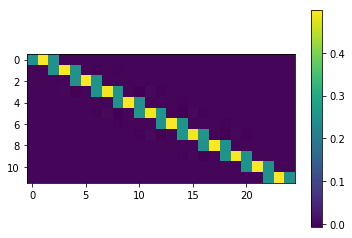

In [11]:
plt.imshow(GLOBALR)
plt.colorbar()

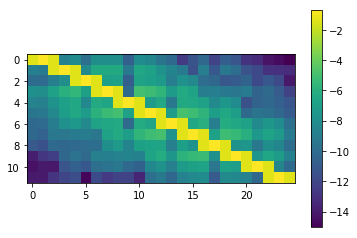

In [12]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

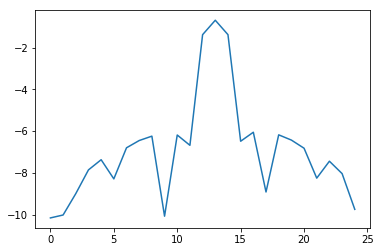

In [13]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
6.597850637624078
L2 norm: 
0.5993957882362577
H1 norm: 
4.681934072751911
Energy norm: 
0.5310861940732409
L2 norm: 
0.8476736529530273
H1 norm: 
0.531251794427514
0.25140101848216895


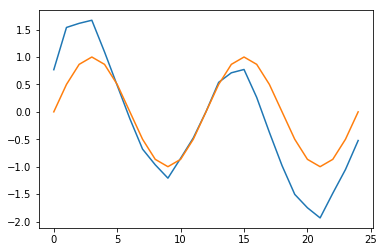

In [14]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)

Energy norm: 
131.71481086872294
L2 norm: 
6.513007759531663
H1 norm: 
87.42141592924563
Energy norm: 
10.625390485202182
L2 norm: 
9.210783905370885
H1 norm: 
9.941103435600706
0.31723607097084094


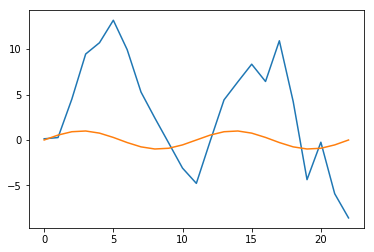

In [15]:
outputsize = np.size(LOCALR,0)
inputsize = np.size(LOCALR,1)
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
h = 1/(inputsize-1)
H = 1/(outputsize-1)
LOCALA = np.zeros([outputsize,outputsize])
for i in range(outputsize):
    for j in range(outputsize):
        basisi = LOCALR[i][:]
        basisj = LOCALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        LOCALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
LOCALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = LOCALR[j][:]
        LOCALF[j][0] = (np.sum(F*basisj))*(H)
        
LOCALU = np.linalg.solve(LOCALA,LOCALF)
LocalU = np.zeros([inputsize,1])
for i in range(outputsize):
    LocalU = LocalU + LOCALU[i]*LOCALR[i][:].reshape([inputsize,1])
    
deltaU = LocalU - Urealfine    

Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)


print(current_rho)

plt.plot(LocalU)
plt.plot(Urealfine)